In [1]:
!pip install traja
# !pip install umap-learn
# !python -m pip istall -U giotto-tda
# !pip install --upgrade dabest
# !pip install hiveplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.3 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import gc
import glob
import matplotlib.ticker as ticker
from matplotlib.patches import Circle, Wedge, Polygon
import matplotlib.patches as patches
import pathlib
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter
# import umap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import ndimage as ndi
import matplotlib as mpl
from statsmodels.stats.multicomp import pairwise_tukeyhsd


# sns.set()
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'
sns.set_context("paper")


# import dabest
import traja


from google.colab import drive
drive.mount('/content/drive')

<ipython-input-2-d95ea63ec75c>:13: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


Mounted at /content/drive


In [3]:
def schmitt_trigger(input, switch_low=6, switch_high=44, init=0):
    mask_low = input < switch_low
    mask_high = input < switch_high
    low = np.insert(np.diff(mask_low.astype(int)), 0, 0)
    high = np.insert(np.diff(mask_high.astype(int)), 0, 0)

    outputs = []
    output = init

    for k in range(len(input)):
        if low[k] == 1:
            output = 1
        elif high[k] == -1:
            output = 0
        outputs.append(output)

    labels, num_labels = ndi.label(outputs)
    outputs = np.array(outputs)

    return outputs, labels, num_labels

def tukeyLetters(pp, means=None, alpha=0.05):
    '''TUKEYLETTERS - Produce list of group labels for TukeyHSD
    letters = TUKEYLETTERS(pp), where PP is a symmetric matrix of
    probabilities from a Tukey test, returns alphabetic labels
    for each group to indicate clustering. PP may also be a vector
    from PAIRWISE_TUKEYHSD.
    Optional argument MEANS specifies group means, which is used for
    ordering the letters. ("a" gets assigned to the group with lowest
    mean.) Without this argument, ordering is arbitrary.
    Optional argument ALPHA specifies cutoff for treating groups as
    part of the same cluster.'''

    if len(pp.shape)==1:
        # vector
        G = int(3 + np.sqrt(9 - 4*(2-len(pp))))//2
        ppp = .5*np.eye(G)
        ppp[np.triu_indices(G,1)] = pp
        pp = ppp + ppp.T
    conn = pp>alpha
    G = len(conn)
    if np.all(conn):
        return ['a' for g in range(G)]
    conns = []
    for g1 in range(G):
        for g2 in range(g1+1,G):
            if conn[g1,g2]:
                conns.append((g1,g2))

    letters = [ [] for g in range(G) ]
    nextletter = 0
    for g in range(G):
        if np.sum(conn[g,:])==1:
            letters[g].append(nextletter)
            nextletter += 1
    while len(conns):
        grp = set(conns.pop(0))
        for g in range(G):
            if all(conn[g, np.sort(list(grp))]):
                grp.add(g)
        for g in grp:
            letters[g].append(nextletter)
        for g in grp:
            for h in grp:
                if (g,h) in conns:
                    conns.remove((g,h))
        nextletter += 1

    if means is None:
        means = np.arange(G)
    means = np.array(means)
    groupmeans = []
    for k in range(nextletter):
        ingroup = [g for g in range(G) if k in letters[g]]
        groupmeans.append(means[np.array(ingroup)].mean())
    ordr = np.empty(nextletter, int)
    ordr[np.argsort(groupmeans)] = np.arange(nextletter)
    result = []
    for ltr in letters:
        lst = [chr(97 + ordr[x]) for x in ltr]
        lst.sort()
        result.append(''.join(lst))
    return result


In [37]:
base_dir_list= [
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{+}{+};{NPF-lexA}{+}/0_4CHV2/male/58mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{+}{+};{NPF-lexA}{+}/0_4CHV2/male/58mW/100ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{+}{+};{NPF-lexA}{+}/0_4CHV2/male/58mW/100ms/starved-fed-3-7-1MS/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{+}{+};{NPF-lexA}{+}/0_4CHV2/male/58mW/100ms/starved-fed-3-7-500S-50NaCl/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{+}{+};{NPF-lexA}{+}/0_4CHV2/male/58mW/100ms/starved-fed-3-7-FF/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{+}{+};{NPF-2A-lexA}{+}/0_4CHV2/male/58mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{+}{+};{NPF-2A-lexA}{+}/0_4CHV2/male/124mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{+}{+};{NPF-2A-lexA}{+}/0_4CHV2/male/58mW/100ms/starved-fed-3-7-500S/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{U-TNT}{y};{Gr43alxA}{p65-AD};{L-CsChr}{GAL4-DBD}/0_4CHV2/male/1mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{U-TNT}{y};{Gr43alxA}{20G06AD};{L-CsChr}{VT055404DBD}/0_4CHV2/male/1mW/100ms/starved/mated/Retinal/',


                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{U-TNT}{y};{Gr43alxA}{20G06AD};{L-CsChr}{VT055404DBD}/0_4CHV2/male/58mW/100ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{U-TNT}{y};{Gr43alxA}{p65-AD};{L-CsChr}{GAL4-DBD}/0_4CHV2/male/1mW/100ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{U-TNT}{y};{Gr43alxA}{20G06AD};{L-CsChr}{VT055404DBD}/0_4CHV2/male/1mW/100ms/starved-fed-3-7-500S/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{U-TNT}{y};{Gr43alxA}{20G06AD};{L-CsChr}{VT055404DBD}/0_4CHV2/male/1mW/100ms/starved-fed-3-7-1MS/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{U-TNT}{y};{Gr43alxA}{p65-AD};{L-CsChr}{GAL4-DBD}/0_4CHV2/male/1mW/100ms/starved-fed-3-7-1MS/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{20G06AD}{U-TNT};{VT055404DBD}{NPF-2A-lexA}/0_4CHV2/male/58mW/100ms/starved-fed-3-7/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{p65-AD}{U-TNT};{GAL4-DBD}{NPF-2A-lexA}/0_4CHV2/male/58mW/100ms/starved-fed-3-7/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{U-TNT}{y};{Ppk28lxA}{p65-AD};{L-CsChr}{GAL4-DBD}/0_4CHV2/male/1mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{U-TNT}{y};{Ppk28lxA}{20G06AD};{L-CsChr}{VT055404DBD}/0_4CHV2/male/1mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{U-TNT}{y};{Ppk28lxA}{p65-AD};{L-CsChr}{GAL4-DBD}/0_4CHV2/male/1mW/100ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{U-TNT}{y};{Ppk28lxA}{20G06AD};{L-CsChr}{VT055404DBD}/0_4CHV2/male/1mW/100ms/starved-fed-3-7-500S/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{p65-AD}{U-TNT};{GAL4-DBD}{NPF-2A-lexA}/0_4CHV2/male/58mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{20G06AD}{U-TNT};{VT055404DBD}{NPF-2A-lexA}/0_4CHV2/male/58mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/P29_{lxAopChr}{y};{11H10AD}{U-TNT};{VT033947DBD}{NPF-2A-lexA}/0_4CHV2/male/58mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/P9_{lxAopChr}{y};{VT023490AD}{U-TNT};{38F04DBD}{NPF-2A-lexA}/0_4CHV2/male/58mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/TLA_{lxAopChr}{y};{VT012330AD}{U-TNT};{VT026742DBD}{NPF-2A-lexA}/0_4CHV2/male/58mW/100ms/starved/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{p65-AD}{U-TNT};{GAL4-DBD}{NPF-2A-lexA}/0_4CHV2/male/58mW/100ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{20G06AD}{U-TNT};{VT055404DBD}{NPF-2A-lexA}/0_4CHV2/male/58mW/100ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/P29_{lxAopChr}{y};{11H10AD}{U-TNT};{VT033947DBD}{NPF-2A-lexA}/0_4CHV2/male/58mW/100ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/P9_{lxAopChr}{y};{VT023490AD}{U-TNT};{38F04DBD}{NPF-2A-lexA}/0_4CHV2/male/58mW/100ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/TLA_{lxAopChr}{y};{VT012330AD}{U-TNT};{VT026742DBD}{NPF-2A-lexA}/0_4CHV2/male/58mW/100ms/starved-fed-3-7-500S/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{U-TNT}{y};{Ppk28lxA}{20G06AD};{L-CsChr}{VT055404DBD}/0_4CHV2/male/1mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{U-TNT}{y};{Ppk28lxA}{20G06AD};{L-CsChr}{VT055404DBD}/0_4CHV2/male/1mW/100ms/starved-fed-3-7/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{U-TNT}{y};{Ppk28lxA}{p65-AD};{L-CsChr}{GAL4-DBD}/0_4CHV2/male/1mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{U-TNT}{y};{Ppk28lxA}{p65-AD};{L-CsChr}{GAL4-DBD}/0_4CHV2/male/1mW/100ms/starved-fed-3-7/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{U-TNT}{y};{Ppk28lxA}{p65-AD};{L-CsChr}{GAL4-DBD}/0_4CHV2/male/1mW/100ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{U-TNT}{y};{Ppk28lxA}{p65-AD};{L-CsChr}{GAL4-DBD}/0_4CHV2/male/1mW/100ms/starved-fed-3-7-1MS/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{+}{+};{NPF-lexA}{+}/0_4CHV2/male/1mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{+}{+};{NPF-lexA}{+}/0_4CHV2/male/15mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{+}{+};{NPF-lexA}{+}/0_4CHV2/male/58mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{+}{+};{Tk-2A-lexA}{+}/0_4CHV2/male/1mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{+}{+};{Tk-2A-lexA}{+}/0_4CHV2/male/58mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{+}{+};{Tk-2A-lexA}{+}/0_4CHV2/male/58mW/100ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{sNPF-2A-lexA}{+};{lxAopCsChr}{+}/0_4CHV2/male/1mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{sNPF-2A-lexA}{+};{lxAopCsChr}{+}/0_4CHV2/male/58mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{sNPF-2A-lexA}{+};{lxAopCsChr}{+}/0_4CHV2/male/58mW/100ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{84C10-lexA}{+};{lxAopCsChr}{+}/0_4CHV2/male/58mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{84C10-lexA}{+};{lxAopCsChr}{+}/0_4CHV2/male/58mW/100ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Or82a-lexA}{+};{lxAopCsChr}{+}/0_4CHV2/male/58mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Or82a-lexA}{+};{lxAopCsChr}{+}/0_4CHV2/male/58mW/100ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Or56a-Gal4}{+};{UASCsChr}{+}/0_4CHV2/male/58mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Or56a-Gal4}{+};{UASCsChr}{+}/0_4CHV2/male/58mW/100ms/starved-fed-3-7-500S/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopCsChr}{y};{+}{+};{Ir56d-lexA}{+}/0_4CHV2/male/58mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopCsChr}{y};{+}{+};{Ir56d-lexA}{+}/0_4CHV2/male/58mW/100ms/starved-fed-3-7-500S/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Ir25aQF2}{+};{QUASCsChrimson}{+}/0_4CHV2/male/1mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Ir25aQF2}{+};{QUASCsChrimson}{+}/0_4CHV2/male/1mW/100ms/starved-fed-3-7-500S/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Or22a-lexA}{+};{lxAopCsChr}{+}/0_4CHV2/male/1mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Or22a-lexA}{+};{lxAopCsChr}{+}/0_4CHV2/male/1mW/100ms/starved-fed-3-7-500S/mated/Retinal/',


                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{20G06AD}{+};{VT055404DBD}{CsChr-mch}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{20G06AD}{+};{VT055404DBD}{CsChr-mch}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{20G06AD}{+};{VT055404DBD}{CsChr-mch}/0_4CHV2/male/58mW/500ms/starved/mated/NoRetinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{20G06AD}{+};{VT055404DBD}{CsChr-mch}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/NoRetinal/',


                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{p65-AD}{U-TNT};{GAL4-DBD}{L-CsChr}/0_4CHV2/male/1mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{20G06AD}{U-TNT};{VT055404DBD}{CsChr-mch}/0_4CHV2/male/1mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/P9_{Gr5alxA}{y};{VT023490AD}{U-TNT};{38F04DBD}{lxAopCsChr}/0_4CHV2/male/1mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/TLA_{Gr5alxA}{y};{VT012330AD}{U-TNT};{VT026742DBD}{lxAopCsChr}/0_4CHV2/male/1mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/P29_{Gr5alxA}{y};{11H10AD}{U-TNT};{VT033947DBD}{lxAopCsChr}/0_4CHV2/male/1mW/100ms/starved/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{p65-AD}{U-TNT};{GAL4-DBD}{L-CsChr}/0_4CHV2/male/1mW/100ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{20G06AD}{U-TNT};{VT055404DBD}{CsChr-mch}/0_4CHV2/male/1mW/100ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/P9_{Gr5alxA}{y};{VT023490AD}{U-TNT};{38F04DBD}{lxAopCsChr}/0_4CHV2/male/1mW/100ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/TLA_{Gr5alxA}{y};{VT012330AD}{U-TNT};{VT026742DBD}{lxAopCsChr}/0_4CHV2/male/1mW/100ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/P29_{Gr5alxA}{y};{11H10AD}{U-TNT};{VT033947DBD}{lxAopCsChr}/0_4CHV2/male/1mW/100ms/starved-fed-3-7-500S/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{U-TNT}{+};{pBDPGAL4Uw}{L-CsChr}/0_4CHV2/male/1mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{U-TNT}{+};{NPF-2A-G4}{L-CsChr}/0_4CHV2/male/1mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{U-TNT}{+};{pBDPGAL4Uw}{L-CsChr}/0_4CHV2/male/1mW/100ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{U-TNT}{+};{NPF-2A-G4}{L-CsChr}/0_4CHV2/male/1mW/100ms/starved-fed-3-7-500S/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopCsChr}{y};{+}{+};{AstA-2A-lexA}{+}/0_4CHV2/male/1mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopCsChr}{y};{+}{+};{AstA-2A-lexA}{+}/0_4CHV2/male/58mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopCsChr}{y};{+}{+};{AstA-2A-lexA}{+}/0_4CHV2/male/58mW/100ms/starved-fed-3-7-500S/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{20G06AD}{U-TNT};{VT055404DBD}{NPF-lexA}/0_4CHV2/male/1mW/100ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{p65-AD}{U-TNT};{GAL4-DBD}{NPF-lexA}/0_4CHV2/male/1mW/100ms/starved-fed-3-7-500S/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{20G06AD}{U-TNT};{VT055404DBD}{NPF-lexA}/0_4CHV2/male/4mW/100ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{p65-AD}{U-TNT};{GAL4-DBD}{NPF-lexA}/0_4CHV2/male/4mW/100ms/starved-fed-3-7-500S/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{20G06AD}{U-TNT};{VT055404DBD}{NPF-lexA}/0_4CHV2/male/15mW/100ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{p65-AD}{U-TNT};{GAL4-DBD}{NPF-lexA}/0_4CHV2/male/15mW/100ms/starved-fed-3-7-500S/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{20G06AD}{U-TNT};{VT055404DBD}{NPF-lexA}/0_4CHV2/male/58mW/100ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{p65-AD}{U-TNT};{GAL4-DBD}{NPF-lexA}/0_4CHV2/male/58mW/100ms/starved-fed-3-7-500S/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{11H10AD}{+};{VT033947DBD}{CsChr-mch}/0_4CHV2/male/58mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{11H10AD}{+};{VT033947DBD}{CsChr-mch}/0_4CHV2/male/58mW/100ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{11H10AD}{+};{VT033947DBD}{CsChr-mch}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{11H10AD}{+};{VT033947DBD}{CsChr-mch}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{11H10AD}{+};{VT033947DBD}{CsChr-mch}/0_4CHV2/male/58mW/500ms/starved/mated/NoRetinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{11H10AD}{+};{VT033947DBD}{CsChr-mch}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/NoRetinal/',


                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{20G06AD}{+};{VT055404DBD}{GtACR1}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{20G06AD}{+};{VT055404DBD}{GtACR1}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{20G06AD}{+};{VT055404DBD}{GtACR1}/0_4CHV2/male/58mW/500ms/starved/mated/NoRetinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{20G06AD}{+};{VT055404DBD}{GtACR1}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/NoRetinal/',


                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{11H10AD}{+};{VT033947DBD}{UAS-GtACR1}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{11H10AD}{+};{VT033947DBD}{UAS-GtACR1}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{11H10AD}{+};{VT033947DBD}{UAS-GtACR1}/0_4CHV2/male/58mW/500ms/starved/mated/NoRetinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{11H10AD}{+};{VT033947DBD}{UAS-GtACR1}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/NoRetinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{p65-AD}{U-TNT};{GAL4-DBD}{Gr64f-lexA}/0_4CHV2/male/58mW/100ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{20G06AD}{U-TNT};{VT055404DBD}{Gr64f-lexA}/0_4CHV2/male/58mW/100ms/starved-fed-3-7-500S/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr64fG4}{p65-AD};{GAL4-DBD}{CsChrimson}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr64fG4}{20G06AD};{VT055404DBD}{CsChrimson}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr64fG4}{p65-AD};{GAL4-DBD}{CsChrimson}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr64fG4}{20G06AD};{VT055404DBD}{CsChrimson}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr64fG4}{p65-AD};{GAL4-DBD}{CsChrimson}/0_4CHV2/male/58mW/500ms/starved/mated/NoRetinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr64fG4}{20G06AD};{VT055404DBD}{CsChrimson}/0_4CHV2/male/58mW/500ms/starved/mated/NoRetinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr64fG4}{p65-AD};{GAL4-DBD}{CsChrimson}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/NoRetinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr64fG4}{20G06AD};{VT055404DBD}{CsChrimson}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/NoRetinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{p65-AD}{CsChrimson};{GAL4-DBD}{NPF-2A-G4}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{20G06AD}{CsChrimson};{VT055404DBD}{NPF-2A-G4}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{p65-AD}{CsChrimson};{GAL4-DBD}{NPF-2A-G4}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{20G06AD}{CsChrimson};{VT055404DBD}{NPF-2A-G4}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr64fG4}{p65-AD};{GAL4-DBD}{CsChrimson}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr64fG4}{11H10AD};{VT033947DBD}{CsChrimson}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr64fG4}{p65-AD};{GAL4-DBD}{CsChrimson}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr64fG4}{11H10AD};{VT033947DBD}{CsChrimson}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5a-G4}{+};{U-CsChr-mch}{+}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5a-G4}{+};{U-CsChr-mch}{+}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{+}{+};{Gr66aG4}{CsChrimson}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{+}{+};{Gr66aG4}{CsChrimson}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr64fG4}{+};{Gr66aG4}{CsChrimson}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr64fG4}{+};{Gr66aG4}{CsChrimson}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{p65-AD}{U-TNT};{GAL4-DBD}{NPF-2A-lexA}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{20G06AD}{U-TNT};{VT055404DBD}{NPF-2A-lexA}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{p65-AD}{U-TNT};{GAL4-DBD}{NPF-2A-lexA}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{20G06AD}{U-TNT};{VT055404DBD}{NPF-2A-lexA}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr64fG4}{+};{CsChrimson}{+}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr64fG4}{+};{CsChrimson}{+}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr66a-lxA}{y};{p65-AD}{U-TNT};{GAL4-DBD}{L-CsChr}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr66a-lxA}{y};{20G06AD}{U-TNT};{VT055404DBD}{L-CsChr}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr66a-lxA}{y};{p65-AD}{U-TNT};{GAL4-DBD}{L-CsChr}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr66a-lxA}{y};{20G06AD}{U-TNT};{VT055404DBD}{L-CsChr}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{p65-AD}{U-TNT};{GAL4-DBD}{Gr64f-lexA}/0_4CHV2/male/58mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{20G06AD}{U-TNT};{VT055404DBD}{Gr64f-lexA}/0_4CHV2/male/58mW/100ms/starved/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{p65-AD}{U-TNT};{GAL4-DBD}{Gr64f-lexA}/0_4CHV2/male/58mW/100ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{20G06AD}{U-TNT};{VT055404DBD}{Gr64f-lexA}/0_4CHV2/male/58mW/100ms/starved-fed-3-7-500S/mated/Retinal/',
                ##################

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{p65-AD}{U-TNT};{GAL4-DBD}{Gr64f-lexA}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{20G06AD}{U-TNT};{VT055404DBD}{Gr64f-lexA}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{p65-AD}{U-TNT};{GAL4-DBD}{Gr64f-lexA}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{20G06AD}{U-TNT};{VT055404DBD}{Gr64f-lexA}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{p65-AD}{U-TNT};{GAL4-DBD}{Gr64f-lexA}/0_4CHV2/male/58mW/500ms/starved/mated/NoRetinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{20G06AD}{U-TNT};{VT055404DBD}{Gr64f-lexA}/0_4CHV2/male/58mW/500ms/starved/mated/NoRetinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{p65-AD}{U-TNT};{GAL4-DBD}{Gr64f-lexA}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/NoRetinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{20G06AD}{U-TNT};{VT055404DBD}{Gr64f-lexA}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/NoRetinal/',
                ##############################

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{p65-AD}{U-NCBac};{GAL4-DBD}{Gr64f-lexA}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{20G06AD}{U-NCBac};{VT055404DBD}{Gr64f-lexA}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{p65-AD}{U-NCBac};{GAL4-DBD}{Gr64f-lexA}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{20G06AD}{U-NCBac};{VT055404DBD}{Gr64f-lexA}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{p65-AD}{U-NCBac};{GAL4-DBD}{Gr64f-lexA}/0_4CHV2/male/58mW/500ms/starved/mated/NoRetinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{20G06AD}{U-NCBac};{VT055404DBD}{Gr64f-lexA}/0_4CHV2/male/58mW/500ms/starved/mated/NoRetinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{p65-AD}{U-NCBac};{GAL4-DBD}{Gr64f-lexA}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/NoRetinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{20G06AD}{U-NCBac};{VT055404DBD}{Gr64f-lexA}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/NoRetinal/',


                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{U-TNT}{y};{Ppk23lxA}{p65-AD};{L-CsChr}{GAL4-DBD}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{U-TNT}{y};{Ppk23lxA}{20G06AD};{L-CsChr}{VT055404DBD}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{U-TNT}{y};{Ppk23lxA}{p65-AD};{L-CsChr}{GAL4-DBD}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{U-TNT}{y};{Ppk23lxA}{20G06AD};{L-CsChr}{VT055404DBD}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{U-TNT}{y};{Ppk28lxA}{p65-AD};{L-CsChr}{GAL4-DBD}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{U-TNT}{y};{Ppk28lxA}{20G06AD};{L-CsChr}{VT055404DBD}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{U-TNT}{y};{Ppk28lxA}{p65-AD};{L-CsChr}{GAL4-DBD}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{U-TNT}{y};{Ppk28lxA}{20G06AD};{L-CsChr}{VT055404DBD}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5a-G4}{p65-AD};{U-CsChr-mch}{GAL4-DBD}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5a-G4}{20G06AD};{U-CsChr-mch}{VT055404DBD}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5a-G4}{p65-AD};{U-CsChr-mch}{GAL4-DBD}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5a-G4}{20G06AD};{U-CsChr-mch}{VT055404DBD}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{p65-AD}{U-TNT};{GAL4-DBD}{L-CsChr}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{20G06AD}{U-TNT};{VT055404DBD}{CsChr-mch}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{p65-AD}{U-TNT};{GAL4-DBD}{L-CsChr}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{20G06AD}{U-TNT};{VT055404DBD}{CsChr-mch}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',


                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{Gr64f-G4}{lexAop-G80};{CsChr-mch}{+}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{Gr64f-G4}{lexAop-G80};{CsChr-mch}{+}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{U-TNT}{y};{Gr43alxA}{p65-AD};{L-CsChr}{GAL4-DBD}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{U-TNT}{y};{Gr43alxA}{20G06AD};{L-CsChr}{VT055404DBD}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{U-TNT}{y};{Gr43alxA}{p65-AD};{L-CsChr}{GAL4-DBD}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{U-TNT}{y};{Gr43alxA}{20G06AD};{L-CsChr}{VT055404DBD}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{+}{+};{nompC-lexA}{+}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{+}{+};{nompC-lexA}{+}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{+}{+};{nompC-lexA}{+}/0_4CHV2/male/58mW/500ms/starved/mated/NoRetinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{+}{+};{nompC-lexA}{+}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/NoRetinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{p65-AD}{U-NaChBac};{GAL4-DBD}{L-CsChr}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/batch1/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{20G06AD}{U-NaChBac};{VT055404DBD}{L-CsChr-mch}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{p65-AD}{U-NaChBac};{GAL4-DBD}{L-CsChr}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/batch1/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{20G06AD}{U-NaChBac};{VT055404DBD}{L-CsChr-mch}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{p65-AD}{U-NaChBac};{GAL4-DBD}{L-CsChr}/0_4CHV2/male/58mW/500ms/starved/mated/NoRetinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{20G06AD}{U-NaChBac};{VT055404DBD}{L-CsChr-mch}/0_4CHV2/male/58mW/500ms/starved/mated/NoRetinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{p65-AD}{U-NaChBac};{GAL4-DBD}{L-CsChr}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/NoRetinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{20G06AD}{U-NaChBac};{VT055404DBD}{L-CsChr-mch}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/NoRetinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{p65-AD}{U-NaChBac};{GAL4-DBD}{L-CsChr}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/batch2/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{11H10AD}{U-NaChBac};{VT033947DBD}{L-CsChr}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{p65-AD}{U-NaChBac};{GAL4-DBD}{L-CsChr}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/batch2/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{11H10AD}{U-NaChBac};{VT033947DBD}{L-CsChr}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{p65-AD}{U-NaChBac};{GAL4-DBD}{L-CsChr}/0_4CHV2/male/58mW/500ms/starved/mated/NoRetinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{11H10AD}{U-NaChBac};{VT033947DBD}{L-CsChr}/0_4CHV2/male/58mW/500ms/starved/mated/NoRetinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{p65-AD}{U-NaChBac};{GAL4-DBD}{L-CsChr}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/NoRetinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{11H10AD}{U-NaChBac};{VT033947DBD}{L-CsChr}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/NoRetinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{+}{U-NaChBac};{empty-G4}{L-CsChr}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{+}{U-NaChBac};{21D12G4}{L-CsChr}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{+}{U-NaChBac};{empty-G4}{L-CsChr}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{+}{U-NaChBac};{21D12G4}{L-CsChr}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr64fG4}{+};{CsChrimson}{+}/0_4CHV2/male/15mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr64fG4}{+};{CsChrimson}{HisCl1-Ri-53932}/0_4CHV2/male/15mW/100ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr64fG4}{+};{CsChrimson}{+}/0_4CHV2/male/15mW/100ms/starved/mated/NoRetinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr64fG4}{+};{CsChrimson}{HisCl1-Ri-53932}/0_4CHV2/male/15mW/100ms/starved/mated/NoRetinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr64fG4}{+};{CsChrimson}{+}/0_4CHV2/male/15mW/100ms/starved-fed-3-7/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr64fG4}{+};{CsChrimson}{HisCl1-Ri-53932}/0_4CHV2/male/15mW/100ms/starved-fed-3-7/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{UstopCsChr}{y};{}{};{HisCl1Gal4}{Gr64f-lexA}/0_4CHV2/male/15mW/500ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{UstopCsChr}{y};{lexAopFlp}{};{HisCl1Gal4}{Gr64f-lexA}/0_4CHV2/male/15mW/500ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{UstopCsChr}{y};{}{};{HisCl1Gal4}{Gr64f-lexA}/0_4CHV2/male/15mW/500ms/fed-3-7/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{UstopCsChr}{y};{lexAopFlp}{};{HisCl1Gal4}{Gr64f-lexA}/0_4CHV2/male/15mW/500ms/fed-3-7/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Dcr2}{y};{Gr64f-G4}{};{CsChr}{w}/0_4CHV2/male/15mW/500ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Dcr2}{y};{Gr64f-G4}{};{CsChr}{hiscl1-ri}/0_4CHV2/male/15mW/500ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Dcr2}{y};{Gr64f-G4}{};{CsChr}{w}/0_4CHV2/male/15mW/500ms/fed-3-7/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Dcr2}{y};{Gr64f-G4}{};{CsChr}{hiscl1-ri}/0_4CHV2/male/15mW/500ms/fed-3-7/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Dcr2}{y};{Gr64f-G4}{};{CsChr}{w}/0_4CHV2/male/15mW/500ms/starved/mated/NoRetinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Dcr2}{y};{Gr64f-G4}{};{CsChr}{hiscl1-ri}/0_4CHV2/male/15mW/500ms/starved/mated/NoRetinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Dcr2}{y};{Gr64f-G4}{};{CsChr}{w}/0_4CHV2/male/15mW/500ms/fed-3-7/mated/NoRetinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Dcr2}{y};{Gr64f-G4}{};{CsChr}{hiscl1-ri}/0_4CHV2/male/15mW/500ms/fed-3-7/mated/NoRetinal/',


                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Dcr2}{y};{Gr64f-G4}{};{CsChr}{w}/0_4CHV2/male/39uW/500ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Dcr2}{y};{Gr64f-G4}{};{CsChr}{hiscl1-ri}/0_4CHV2/male/39uW/500ms/starved/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Dcr2}{y};{Gr64f-G4}{};{CsChr}{w}/0_4CHV2/male/39uW/500ms/fed-3-7/mated/Retinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Dcr2}{y};{Gr64f-G4}{};{CsChr}{hiscl1-ri}/0_4CHV2/male/39uW/500ms/fed-3-7/mated/Retinal/',

                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Dcr2}{y};{Gr64f-G4}{};{CsChr}{w}/0_4CHV2/male/39uW/500ms/starved/mated/NoRetinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Dcr2}{y};{Gr64f-G4}{};{CsChr}{hiscl1-ri}/0_4CHV2/male/39uW/500ms/starved/mated/NoRetinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Dcr2}{y};{Gr64f-G4}{};{CsChr}{w}/0_4CHV2/male/39uW/500ms/fed-3-7/mated/NoRetinal/',
                # '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Dcr2}{y};{Gr64f-G4}{};{CsChr}{hiscl1-ri}/0_4CHV2/male/39uW/500ms/fed-3-7/mated/NoRetinal/',

                '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{p65-AD}{U-NaChBac};{GAL4-DBD}{L-CsChr}/0_4CHV2/male/58mW/500ms/starved/mated/NoRetinal/',
                '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr64fG4}{+};{CsChrimson}{+}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',
                '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{20G06AD}{U-NaChBac};{VT055404DBD}{L-CsChr-mch}/0_4CHV2/male/58mW/500ms/starved/mated/NoRetinal/',
                '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{U-TNT}{y};{Gr43alxA}{p65-AD};{L-CsChr}{GAL4-DBD}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',
                '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{20G06AD}{U-NCBac};{VT055404DBD}{Gr64f-lexA}/0_4CHV2/male/58mW/500ms/starved/mated/NoRetinal/',
                '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5a-G4}{+};{U-CsChr-mch}{+}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',
                '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{lxAopChr}{y};{20G06AD}{U-NCBac};{VT055404DBD}{Gr64f-lexA}/0_4CHV2/male/58mW/500ms/starved-fed-3-7-500S/mated/NoRetinal/',
                '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{+}{+};{Gr66aG4}{CsChrimson}/0_4CHV2/male/58mW/500ms/starved/mated/Retinal/',



















]
fnames_list = []

for i, dir in enumerate(base_dir_list):
    fnames = sorted(glob.glob(base_dir_list[i]+ '/*.csv', recursive=True))
    fnames_list.append(fnames)
print(len(fnames_list))
fnames_list





8


[['/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{p65-AD}{U-NaChBac};{GAL4-DBD}{L-CsChr}/0_4CHV2/male/58mW/500ms/starved/mated/NoRetinal/01-1_4CHV2_{Gr5alxA}{y};{p65-AD}{U-NaChBac};{GAL4-DBD}{L-CsChr}_male_58mW_500ms_starved_mated_NoRetinal-2023-01-05T10_40_17.csv',
  '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{p65-AD}{U-NaChBac};{GAL4-DBD}{L-CsChr}/0_4CHV2/male/58mW/500ms/starved/mated/NoRetinal/02-2_4CHV2_{Gr5alxA}{y};{p65-AD}{U-NaChBac};{GAL4-DBD}{L-CsChr}_male_58mW_500ms_starved_mated_NoRetinal-2023-01-05T10_40_17.csv',
  '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/{Gr5alxA}{y};{p65-AD}{U-NaChBac};{GAL4-DBD}{L-CsChr}/0_4CHV2/male/58mW/500ms/starved/mated/NoRetinal/03-3_4CHV2_{Gr5alxA}{y};{p65-AD}{U-NaChBac};{GAL4-DBD}{L-CsChr}_male_58mW_500ms_starved_mated_NoRetinal-2023-01-05T10_40_17.csv',
  '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch

In [38]:
data_header = ['time', 'latency', 'x', 'y', 'led_state']
# category = ['s', 'sf1', 'sf3', 'sf5']
length = 50
width = 1080
groups = {}
all_df = []
revisits_per_search = []
center_mass_dist = []
# search_dist = []
zone_return_list =[]

first_acts = []
duplicates = []
nans = []
for j, sub_fnames_list in enumerate(fnames_list):
    print('group', j)
    find_duplicate = []

    for i, fname in enumerate(sub_fnames_list):
        path = pathlib.PurePath(fname)
        print(i, path.name)
        groups['group_' + str(j) + '_'+ str(i)] = path.name
        df = pd.read_csv(fname, header=None)
        df.columns = data_header
        df['latency'][0] = 0
        df['time'] = df['time'] - df['time'][0]
        df[['x', 'y']] = df[['x', 'y']] * (length/width)

        # Check duplicates or empty dataframes
        test_num = df[['x', 'y']][:2].values.mean()
        if (np.isnan(test_num)):
            nans.append(fname)

        if test_num not in find_duplicate:
            find_duplicate.append(test_num)
        elif (test_num in find_duplicate):
            duplicates.append(fname)

        trj = traja.TrajaDataFrame(df[['x', 'y', 'time']])
        trj['latency'] = df['latency']
        # trj['displacement'] = trj.traja.calc_displacement()
        trj[['displacement', 'displacement_time', 'speed', 'speed_times', 'acceleration', 'acceleration_times']] = trj.traja.get_derivatives()
        trj['cumul_displacement'] = trj['displacement'].cumsum()
        trj['angle'] = trj.traja.calc_angle()
        trj['heading'] = trj.traja.calc_heading()
        trj['turn_angle'] = trj.traja.calc_turn_angle()

        # velocity:
        trj['v_x'] = np.where((trj['x'].diff().values)>=0, 1, -1) * trj['speed']

        # Led state adjustment:
        trj['led_state'] = df.led_state.shift(3).fillna(False)

        # Number of fly:
        trj['fly'] = i+1
        trj['group'] = 'group_' + str(j)

        intervals = traja.speed_intervals(trj[['x', 'y', 'time']], slower_than=0.5)

        # print(intervals.duration.quantile(0.99))
        # intervals.hist('duration', bins=20)
        # plt.show()

        # print(intervals[intervals.duration >= 2])
        stop_sec = 3
        stop_intervals = intervals[intervals.duration >= stop_sec]
        slice_start = stop_intervals.start_frame
        slice_stop = stop_intervals.stop_frame

        trj['stop'] = np.nan

        for tup in list(stop_intervals[['start_frame', 'stop_frame']].itertuples(index=False, name=None)):
            trj.stop[slice(tup[0], tup[1])] = 1

        trj['cumsum_led_state'] = trj.led_state.cumsum()

        # Local search bout:
        outputs, labels, num_labels = schmitt_trigger(input=trj.x.values,
                                                      switch_low=6,
                                                      switch_high=44, init=0)

        trj['search_bout'] = labels
        trj['search_bout'][trj.search_bout == 0] = np.nan
        trj['return_walkaway'] = np.nan
        trj['excursion'] = np.nan

        return_count = []
        walkaway_count = []
        exc_per_search = []
        fly_in_zone = []

        for l in trj.search_bout.unique()[1:]: # excluded NaN labels
            bout = trj[trj.search_bout == l].copy()
            slc_idx = bout[bout.led_state==True].index.values

            for k, v in enumerate(slc_idx):
                if k != len(slc_idx)-1:
                    slc = slice(slc_idx[k], slc_idx[k+1])

                    if (trj.stop[slc] != 1).all(): # If there is no stop event:
                        trj.excursion[slc] = k+1
                        trj.return_walkaway[slc] = 'return'
                        return_count.append(1)

                    else:
                        trj.excursion[slc] = k+1
                        trj.return_walkaway[slc] = 'walkaway'
                        walkaway_count.append(1)

                else:
                    slc = slice(slc_idx[k], None) # the last excursion
                    trj.excursion[slc] = k+1
                    trj.return_walkaway[slc] = 'walkaway'
                    walkaway_count.append(1)
            try:
                ex_max = trj.excursion.unique()[1:].max() -1
            except ValueError:  #raised if `y` is empty.
                pass

            exc_per_search.append(ex_max)

        if (len(return_count) + len(walkaway_count)) == 0:
            print('Return: The file above excluded!')
        else:
            # excursion/search_bout:
            num_search = len(trj.search_bout.unique()[1:])
            num_excursion = len(trj.excursion.unique()[1:])
            exc_search = np.array(exc_per_search).mean()
            # print(num_excursion, num_search)
            # Return probability:
            return_prob = len(return_count) * 100 / (len(return_count) + len(walkaway_count))

            # Zone:
            conditions = [
                        (trj['x'] <= 6), # zone1
                        (trj['x'] >= 44), # zone2
                        (trj['x'] > 9) & (trj['x'] < 41), # zone3
                        ((trj['x'] > 6) & (trj['x'] <= 9)) & ((trj['x'] >= 41) & (trj['x'] < 44))] # reset zone
            choices = [1, 2, 3, np.nan] # NaN stands for reward zone.
            trj['zone'] = np.select(conditions, choices, default=np.nan)

            time_after_activation = trj[(trj['zone']==1)].latency.sum()/(num_search*num_excursion)
            speed_in_zone_A = trj[(trj['zone']==1)].speed.sum()/len(trj[(trj['zone']==1) ].speed)
            center_of_mass = 50 - trj.x.median()

            # Zone PI:
            first_act_idx = trj[trj.led_state==True].index.values[0]
            first_acts.append(first_act_idx)
            print('The first activation at: ', first_act_idx)
            if first_act_idx <= 3800:
                _df = trj[first_act_idx:]
                z1_occu = _df[(_df.zone == 1) & (_df.stop!=1)].latency.sum()
                z2_occu = _df[(_df.zone == 2) & (_df.stop!=1)].latency.sum()
                pi = (z1_occu - z2_occu) / (z1_occu + z2_occu)
                zone_return_list.append(['group_' + str(j), trj.fly.unique()[0], pi, return_prob, exc_search, time_after_activation, speed_in_zone_A, center_of_mass])
            else:
                print('PI: The file above excluded!')

            all_df.append(trj)

# zone_pi_df = pd.DataFrame(zone_pi_list, columns=['group', 'fly', 'zone_pi'])
# return_prob_df = pd.DataFrame(return_prob_list, columns=['group', 'fly', 'return_prob'])
zone_return_df = pd.DataFrame(zone_return_list, columns=['group', 'fly', 'zone_pi', 'return_prob', 'revisits_per_travel', 'time_after_activation', 'speed_in_zone_A', 'center_of_mass'])
# print(zone_pi_df)
print(zone_return_df)
all_df = pd.concat(all_df)
all_df.drop(['displacement_time', 'speed_times', 'acceleration_times'], axis=1, inplace=True)
all_df.head(10)

group 0
0 01-1_4CHV2_{Gr5alxA}{y};{p65-AD}{U-NaChBac};{GAL4-DBD}{L-CsChr}_male_58mW_500ms_starved_mated_NoRetinal-2023-01-05T10_40_17.csv
The first activation at:  236
1 02-2_4CHV2_{Gr5alxA}{y};{p65-AD}{U-NaChBac};{GAL4-DBD}{L-CsChr}_male_58mW_500ms_starved_mated_NoRetinal-2023-01-05T10_40_17.csv
The first activation at:  175
2 03-3_4CHV2_{Gr5alxA}{y};{p65-AD}{U-NaChBac};{GAL4-DBD}{L-CsChr}_male_58mW_500ms_starved_mated_NoRetinal-2023-01-05T10_40_17.csv
The first activation at:  216
3 04-4_4CHV2_{Gr5alxA}{y};{p65-AD}{U-NaChBac};{GAL4-DBD}{L-CsChr}_male_58mW_500ms_starved_mated_NoRetinal-2023-01-05T10_40_17.csv
The first activation at:  194
4 05-1_4CHV2_{Gr5alxA}{y};{p65-AD}{U-NaChBac};{GAL4-DBD}{L-CsChr}_male_58mW_500ms_starved_mated_NoRetinal-2023-01-05T11_09_42.csv
The first activation at:  222
5 06-2_4CHV2_{Gr5alxA}{y};{p65-AD}{U-NaChBac};{GAL4-DBD}{L-CsChr}_male_58mW_500ms_starved_mated_NoRetinal-2023-01-05T11_09_42.csv
The first activation at:  73
6 08-4_4CHV2_{Gr5alxA}{y};{p65-AD

,x,y,time,latency,displacement,speed,acceleration,cumul_displacement,angle,heading,...,v_x,led_state,fly,group,stop,cumsum_led_state,search_bout,return_walkaway,excursion,zone
0,12.993912,3.661518,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,False,1,group_0,NaN,0,NaN,NaN,NaN,3.0
1,13.386250,3.632869,0.042217,0.042217,0.393383,9.318108,NaN,0.393383,4.176407,-4.176407,...,9.318108,False,1,group_0,NaN,0,NaN,NaN,NaN,3.0
2,13.572991,3.831758,0.067063,0.024846,0.272817,10.980285,66.898922,0.666200,46.804475,46.804475,...,10.980285,False,1,group_0,NaN,0,NaN,NaN,NaN,3.0
3,13.792597,3.612340,0.098711,0.031648,0.310437,9.809157,-37.005169,0.976637,44.975409,-44.975409,...,9.809157,False,1,group_0,NaN,0,NaN,NaN,NaN,3.0
4,14.120704,3.203217,0.133086,0.034375,0.524438,15.256478,158.468443,1.501075,51.271263,-51.271263,...,15.256478,False,1,group_0,NaN,0,NaN,NaN,NaN,3.0
5,14.415583,2.799764,0.166096,0.033010,0.499728,15.138458,-3.575227,2.000804,53.837301,-53.837301,...,15.138458,False,1,group_0,NaN,0,NaN,NaN,NaN,3.0
6,14.713949,2.395999,0.201047,0.034951,0.502045,14.364244,-22.151397,2.502848,53.537172,-53.537172,...,14.364244,False,1,group_0,NaN,0,NaN,NaN,NaN,3.0
7,14.871472,1.995133,0.232144,0.031097,0.430705,13.850330,-16.526117,2.933553,68.547289,-68.547289,...,13.850330,False,1,group_0,NaN,0,NaN,NaN,NaN,3.0
8,15.188458,1.594556,0.265572,0.033428,0.510824,15.281335,42.808572,3.444378,51.644551,-51.644551,...,15.281335,False,1,group_0,NaN,0,NaN,NaN,NaN,3.0
9,15.406125,1.325063,0.299233,0.033661,0.346418,10.291461,-148.240347,3.790796,51.072560,-51.072560,...,10.291461,False,1,group_0,NaN,0,NaN,NaN,NaN,3.0


In [39]:
duplicates

[]

In [40]:
nans

[]

In [41]:
all_df.stop.unique()

array([nan,  1.])

In [42]:
columns = ['zone_pi', 'return_prob', 'revisits_per_travel', 'time_after_activation', 'speed_in_zone_A', 'center_of_mass']

for c in columns:
    # if i == 0:
    #     target_col = 'zone_pi'
    # else:
    #     target_col = 'return_prob'
    #     target_col = 'time_after_activation'
    df_wide=pd.pivot(zone_return_df,  index='fly', columns ='group' ,values = c)

    Q1 = df_wide.quantile(0.25)
    Q3 = df_wide.quantile(0.75)

    IQR = Q3 - Q1
    lower_lim = Q1 - 1.5*IQR
    upper_lim = Q3 + 1.5*IQR



    outliers_low = (df_wide < lower_lim)
    outliers_up = (df_wide > upper_lim)

    # df_wide[(outliers_low | outliers_up)]
    # print(df_wide[(outliers_low | outliers_up)])


    fname = c + 'Grs_Preference_result.csv'
    df_wide.to_csv('/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/forNY/' + fname)
    print('******************************************************************')
    print(c)
    print('******************************************************************')
    print(df_wide.describe())
    print('')
    print(df_wide)
    print('')


******************************************************************
zone_pi
******************************************************************
group    group_0    group_1    group_2    group_3    group_4    group_5  \
count  12.000000  20.000000  11.000000  12.000000  16.000000  20.000000   
mean    0.137579   0.543112   0.054945   0.379603   0.245471   0.708271   
std     0.102153   0.437714   0.104541   0.161016   0.113257   0.175117   
min    -0.045799  -0.399213  -0.096777   0.173540   0.061646   0.382223   
25%     0.103709   0.279773  -0.004608   0.260316   0.152433   0.569174   
50%     0.139640   0.629966   0.067038   0.394260   0.237259   0.699199   
75%     0.185156   0.901667   0.083731   0.452224   0.328034   0.822059   
max     0.331318   1.000000   0.263625   0.674501   0.441683   1.000000   

group    group_6    group_7  
count  12.000000  18.000000  
mean    0.290566  -0.953902  
std     0.094782   0.046146  
min     0.146973  -0.989632  
25%     0.238409  -0.984765  
50

group_0


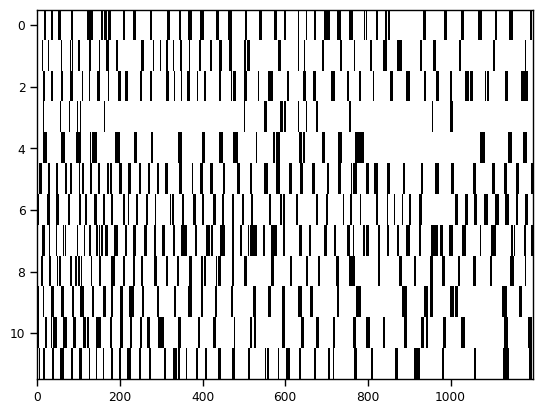

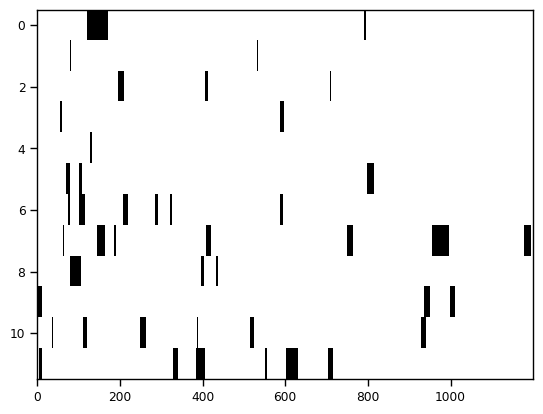

group_1


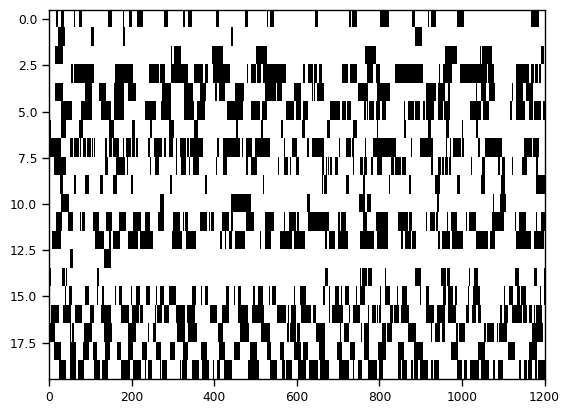

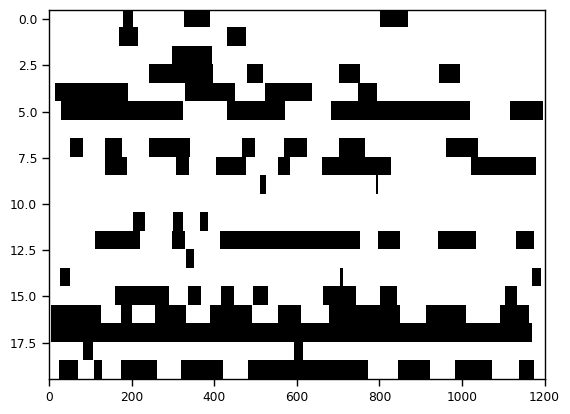

group_2


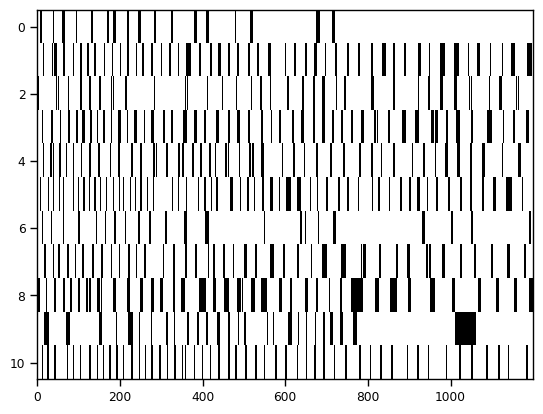

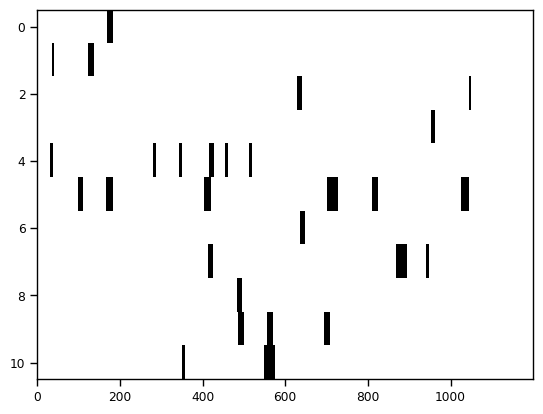

group_3


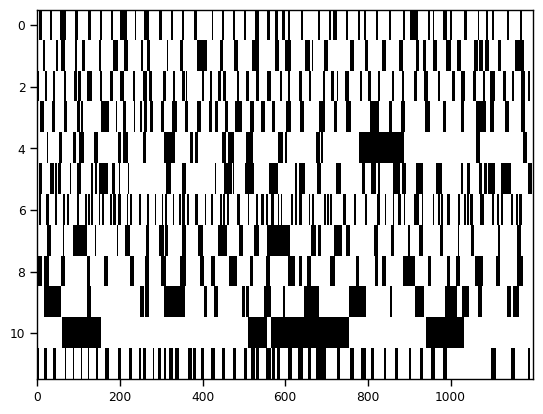

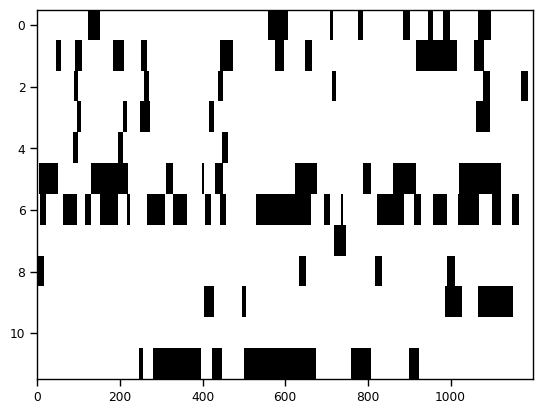

group_4


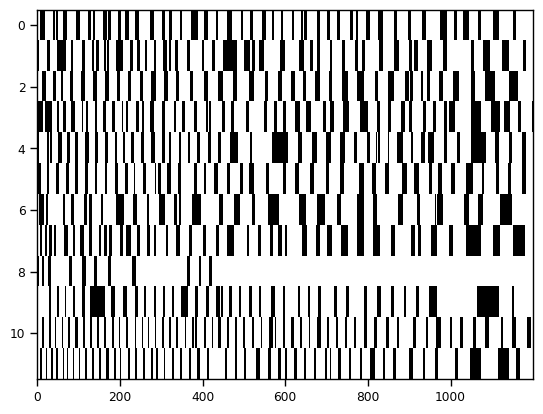

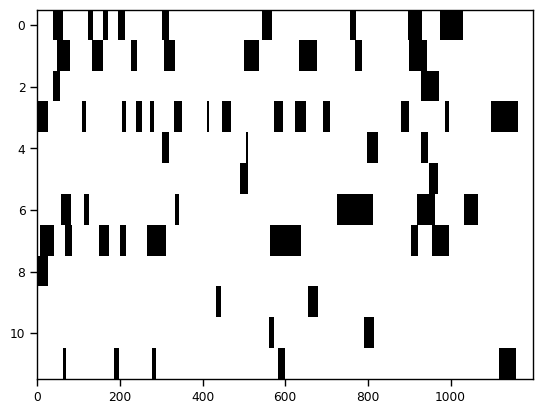

group_5


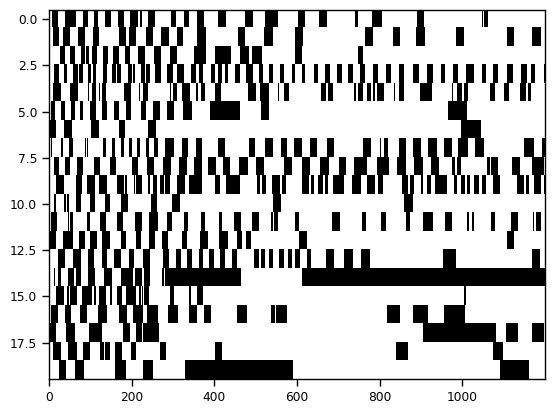

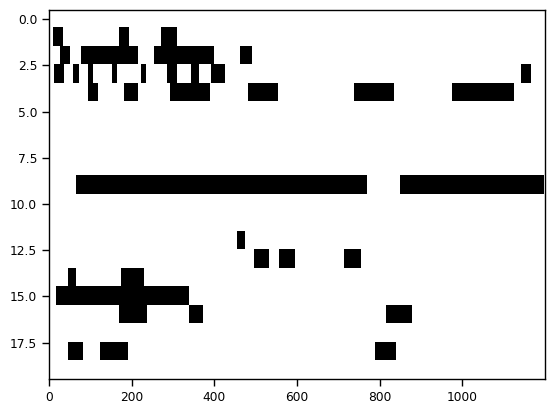

group_6


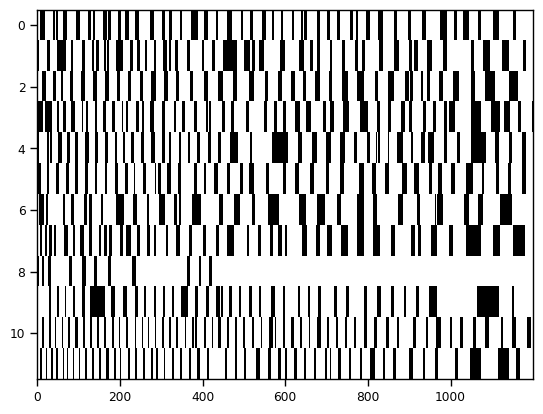

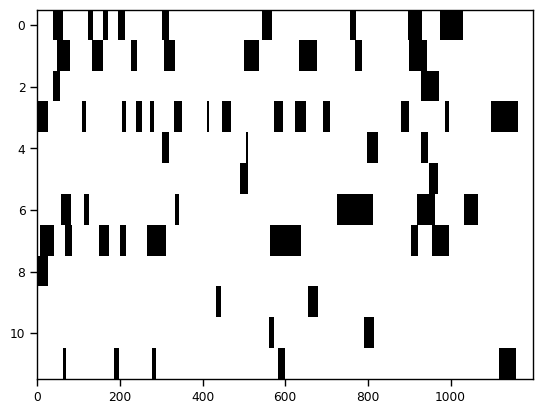

group_7


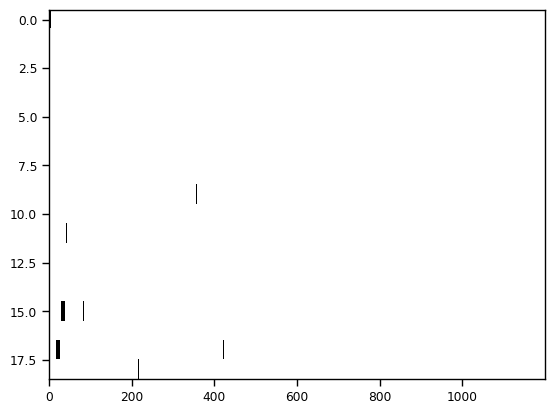

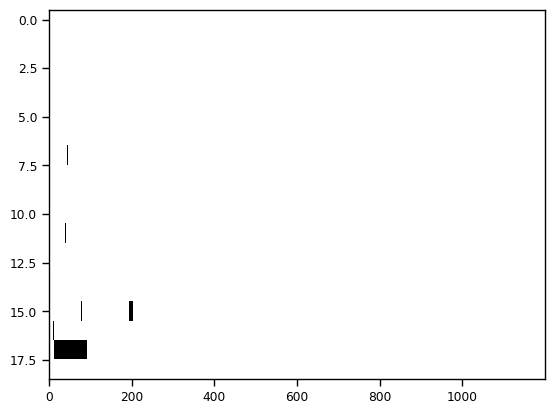

In [35]:
arr = all_df['return_walkaway'].values
arr = np.where(arr=='return', 1, 0)
all_df['return_binary'] = arr
all_df['group_time'] = (all_df.time // 0.5) / 2
for i in all_df.group.unique():
    print(i)
    group_df = all_df[all_df.group==i]
    group_df = group_df[['fly', 'group_time', 'return_binary', 'x']].groupby(['fly', 'group_time']).mean()
    arr = group_df.return_binary.values
    arr = np.where(arr>=1, 1, 0)
    group_df.return_binary = arr
    arr = group_df.x.values
    arr = np.where(arr<=6, 1, 0)
    group_df.x = arr
    group_df.reset_index()
    for j in range(2):
        values = ['x', 'return_binary']
        pvt = group_df.pivot_table(index='fly', columns=['group_time'], values=values[j])
        plt.imshow(pvt, aspect='auto', interpolation='none', cmap='Greys')

        fig_title = 'raster_' + str(i) + '_' + values[j] + '_Gr64f_CsChr_SEZ3_CsChr'
        base_path = '/content/drive/My Drive/01_paper/SEZ3/raw_data/' + fig_title
        fig_path = base_path + '.svg'

        # plt.savefig(fig_path, format='svg' , transparent=True, bbox_inches='tight', pad_inches=0.0, dpi=600)

        plt.show()

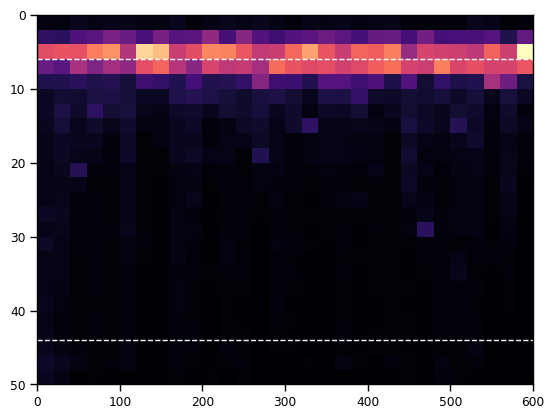

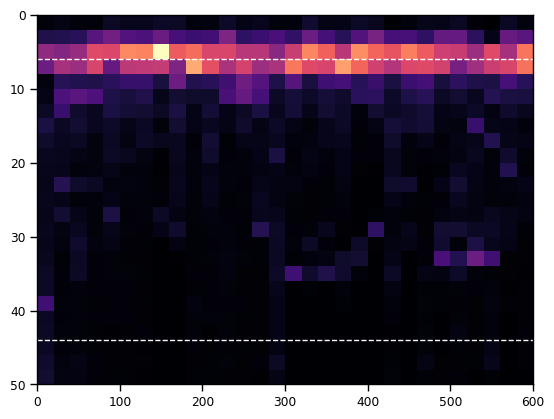

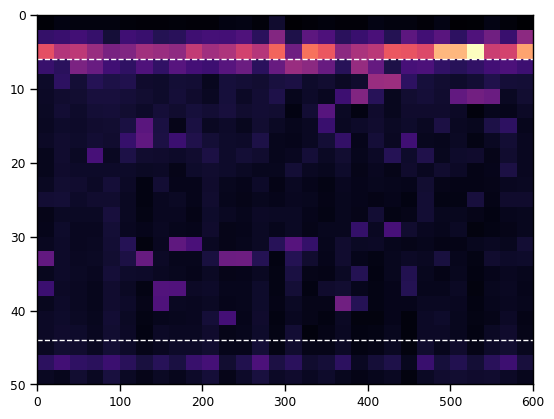

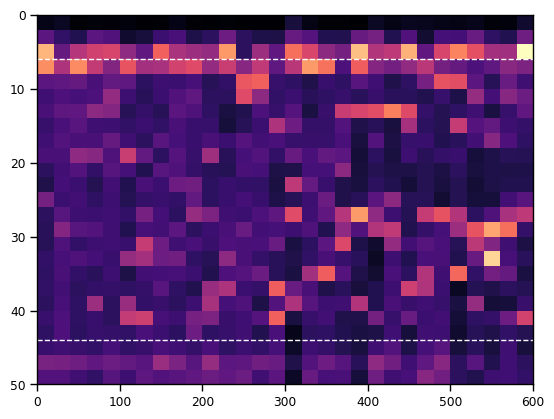

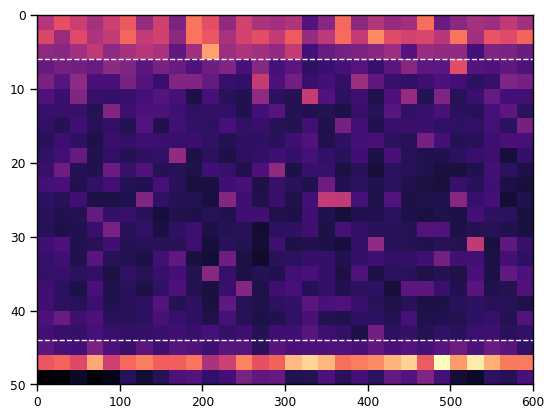

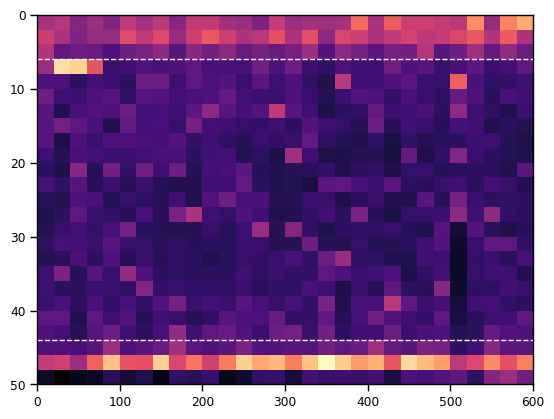

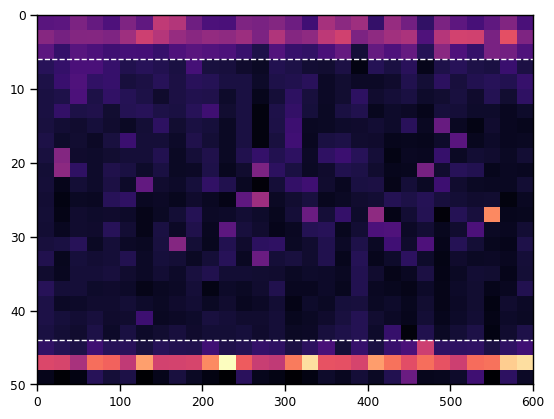

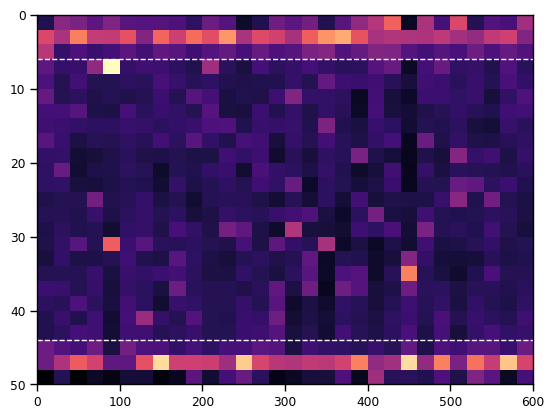

In [ ]:
for g in all_df.group.unique():
    hist_2d = all_df[(all_df.group==g)]
    plt.hist2d(data=hist_2d, x='time', y='x', bins=[30, 25], range=[[0, 600], [0, 50]],
               density=True,
               norm=mpl.colors.Normalize(),
               cmap='magma')
    plt.ylim([0, 50])
    plt.axhline(6, c='w', lw=1, linestyle='--')
    plt.axhline(44, c='w', lw=1, linestyle='--')
    # plt.axvline(200, c='w', lw=1, linestyle='--')
    # plt.axvline(400, c='w', lw=1, linestyle='--')

    fig_title = '2Dhist_' + str(g) + '_Gr64f_CsChr_SEZ3_CsChr'
    base_path = '/content/drive/My Drive/01_paper/SEZ3/raw_data/' + fig_title
    fig_path = base_path + '.svg'

    # plt.savefig(fig_path, format='svg' , transparent=True, bbox_inches='tight', pad_inches=0.0, dpi=600)

    plt.gca().invert_yaxis()
    plt.show()

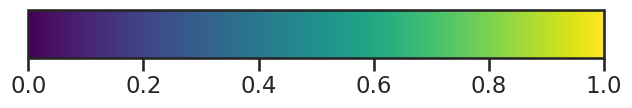

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig = plt.figure()
ax = fig.add_axes([0.05, 0.80, 0.9, 0.1])
# cmap=mpl.colormaps['magma']
cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal',
                               cmap=plt.cm.viridis)
fig_title = 'viridis_colorbar' +'_Gr64f_CsChrimson'
base_path = '/content/drive/My Drive/01_paper/SEZ3/raw_data/' + fig_title
fig_path = base_path + '.svg'

# plt.savefig(fig_path, format='svg' , transparent=True, bbox_inches='tight', pad_inches=0.0, dpi=600)

In [ ]:
print(sns.color_palette('Greys_r', 4).as_hex())
print(sns.color_palette('flare_r', 4).as_hex())
print(sns.color_palette('crest_r', 4).as_hex())


'''
[‘Accent’, ‘Accent_r’, ‘Blues’, ‘Blues_r’, ‘BrBG’, ‘BrBG_r’, ‘BuGn’, ‘BuGn_r’, ‘BuPu’, ‘BuPu_r’,
 ‘CMRmap’, ‘CMRmap_r’, ‘Dark2’, ‘Dark2_r’, ‘GnBu’, ‘GnBu_r’, ‘Greens’, ‘Greens_r’, ‘Greys’, ‘Greys_r’, ‘OrRd’,
 ‘OrRd_r’, ‘Oranges’, ‘Oranges_r’, ‘PRGn’, ‘PRGn_r’, ‘Paired’, ‘Paired_r’, ‘Pastel1’,
 ‘Pastel1_r’, ‘Pastel2’, ‘Pastel2_r’, ‘PiYG’, ‘PiYG_r’, ‘PuBu’, ‘PuBuGn’, ‘PuBuGn_r’,
 ‘PuBu_r’, ‘PuOr’, ‘PuOr_r’, ‘PuRd’, ‘PuRd_r’, ‘Purples’, ‘Purples_r’, ‘RdBu’, ‘RdBu_r’,
 ‘RdGy’, ‘RdGy_r’, ‘RdPu’, ‘RdPu_r’, ‘RdYlBu’, ‘RdYlBu_r’, ‘RdYlGn’, ‘RdYlGn_r’, ‘Reds’,
 ‘Reds_r’, ‘Set1’, ‘Set1_r’, ‘Set2’, ‘Set2_r’, ‘Set3’, ‘Set3_r’, ‘Spectral’, ‘Spectral_r’,
 ‘Wistia’, ‘Wistia_r’, ‘YlGn’, ‘YlGnBu’, ‘YlGnBu_r’, ‘YlGn_r’, ‘YlOrBr’, ‘YlOrBr_r’, ‘YlOrRd’,
 ‘YlOrRd_r’, ‘afmhot’, ‘afmhot_r’, ‘autumn’, ‘autumn_r’, ‘binary’, ‘binary_r’, ‘bone’,
 ‘bone_r’, ‘brg’, ‘brg_r’, ‘bwr’, ‘bwr_r’, ‘cividis’, ‘cividis_r’, ‘cool’, ‘cool_r’, ‘coolwarm’, ‘coolwarm_r’, ‘copper’, ‘copper_r’,
 ‘cubehelix’, ‘cubehelix_r’, ‘flag’, ‘flag_r’, ‘gist_earth’, ‘gist_earth_r’, ‘gist_gray’, ‘gist_gray_r’, ‘gist_heat’, ‘gist_heat_r’, ‘gist_ncar’, ‘gist_ncar_r’,
 ‘gist_rainbow’, ‘gist_rainbow_r’, ‘gist_stern’, ‘gist_stern_r’, ‘gist_yarg’,
 ‘gist_yarg_r’, ‘gnuplot’, ‘gnuplot2’, ‘gnuplot2_r’, ‘gnuplot_r’, ‘gray’, ‘gray_r’,
 ‘hot’, ‘hot_r’, ‘hsv’, ‘hsv_r’, ‘icefire’, ‘icefire_r’, ‘inferno’,
 ‘inferno_r’, ‘magma’, ‘magma_r’, ‘mako’, ‘mako_r’,
 ‘nipy_spectral’, ‘nipy_spectral_r’, ‘ocean’, ‘ocean_r’, ‘pink’, ‘pink_r’,
 ‘plasma’, ‘plasma_r’, ‘prism’, ‘prism_r’, ‘rainbow’, ‘rainbow_r’,
 ‘rocket’, ‘rocket_r’, ‘seismic’, ‘seismic_r’, ‘spring’, ‘spring_r’,
 ‘summer’, ‘summer_r’, ‘tab10’, ‘tab10_r’, ‘tab20’, ‘tab20_r’, ‘tab20b’,
 ‘tab20b_r’, ‘tab20c’, ‘tab20c_r’, ‘terrain’, ‘terrain_r’, ‘twilight’,
 ‘twilight_r’, ‘twilight_shifted’, ‘twilight_shifted_r’, ‘viridis’, ‘viridis_r’, ‘vlag’, ‘vlag_r’, ‘winter’, ‘winter_r’]
 '''
print(sns.color_palette('crest_r', 2).as_hex())
sns.color_palette('crest_r', 2)
# mako:UAS-TNT


['#404040', '#7a7a7a', '#b5b5b5', '#e2e2e2']
['#7a2e70', '#aa3a6e', '#d64f5f', '#e77e63']
['#215584', '#24768b', '#44948f', '#6db290']
['#1d6c8a', '#509e90']


[(0.11409965, 0.42169502, 0.54065622), (0.31270304, 0.62072111, 0.56379321)]

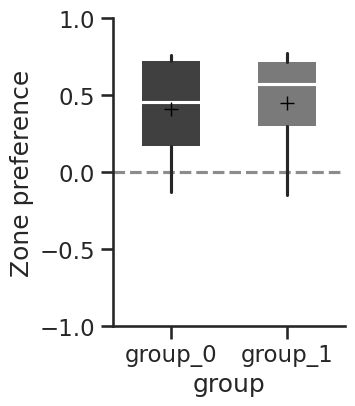

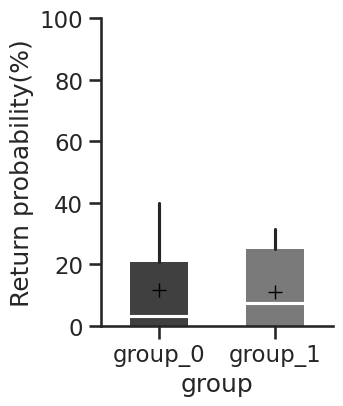

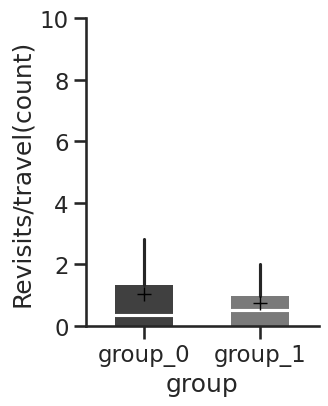

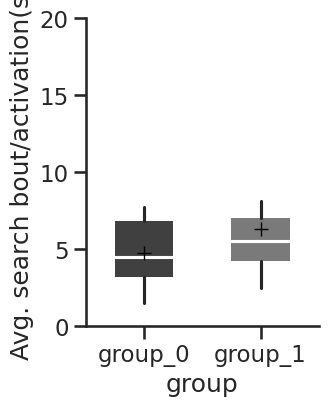

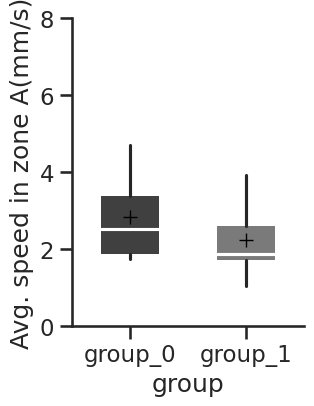

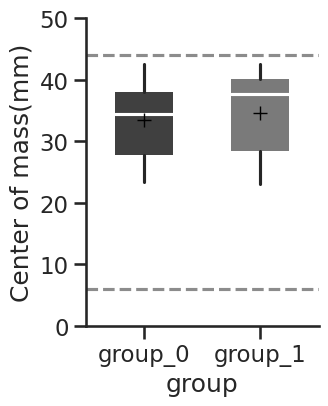

In [ ]:
sns.set_theme(style="ticks")
sns.set_context("talk")

palette_test = sns.color_palette('Greys_r', 4)
# palette_test = sns.color_palette('flare_r', 2)
palette_control = sns.color_palette('bone', 4)
# palette_control = sns.color_palette('crest_r', 2)

my_color_palette = {'group_0': palette_test[0],
                    'group_1': palette_test[1],
                    'group_2': palette_test[2],
                    'group_3': palette_test[3],
                    'group_4': palette_test[0],
                    'group_5': palette_test[1],
                    'group_6': palette_test[2],
                    'group_7': palette_test[3],
                    'group_8': palette_test[0],
                    'group_9': palette_test[1],
                    'group_10': palette_test[2],
                    'group_11': palette_test[3],
                    }

# my_color_palette = {'group_0': palette_control[0],
#                     'group_1': palette_control[1],
#                     'group_2': palette_test[0],
#                     'group_3': palette_test[1],
#                     }
PROPS = {
    'boxprops':{'edgecolor':'none'},
    'medianprops':{'color':'white'},
    # 'whiskerprops':{'color':'blue'},
    'capprops':{'color':'none'}
}

columns = ['zone_pi', 'return_prob', 'revisits_per_travel', 'time_after_activation', 'speed_in_zone_A', 'center_of_mass']
for c in columns:
# for i in range(3):
    # col = zone_return_df.columns[2:][i]
    # data  = zone_return_df[col]
    # group = zone_return_df['group']
    # tuk = pairwise_tukeyhsd(data, group)
    # letters = tukeyLetters(tuk.pvalues)
    # print('****************** ' + col + ' ******************')
    # print(letters)
    # print(tuk.summary())

    fig, ax = plt.subplots(figsize=(3,4))
    # fig, ax = plt.subplots(figsize=(5,4))
    # fig, ax = plt.subplots(figsize=(6,4))

    if c == 'zone_pi':
        ylim = [-1, 1]
        ylabel = 'Zone preference'
        ax.axhline(0, color='k', alpha=0.5, linestyle='--')

    elif c == 'return_prob':
        ylim = [0, 100]
        ylabel = 'Return probability(%)'

    elif c == 'revisits_per_travel':
        ylim = [0, 10]
        ylabel = 'Revisits/travel(count)'

    elif c == 'time_after_activation':
        ylim = [0, 20]
        ylabel = 'Avg. search bout/activation(s)'

    elif c == 'speed_in_zone_A':
        ylim = [0, 8]
        ylabel = 'Avg. speed in zone A(mm/s)'

    elif c == 'center_of_mass':
        ylim = [0, 50]
        ylabel = 'Center of mass(mm)'
        ax.axhline(44, color='k', alpha=0.5, linestyle='--')
        ax.axhline(6, color='k', alpha=0.5, linestyle='--')


    sns.boxplot(
                x='group',
                y=c,
                hue='group',
                # color='k',
                # palette='viridis',
                palette=my_color_palette,
                width=0.5,
                showmeans=True,
                meanprops={"marker":"+",
                       "markeredgecolor":"black",
                       "markersize":"10"},
                showfliers=False,
                # ci=68,
                # scale=0.7,
                dodge=False,
                data=zone_return_df,
                ax=ax,
                **PROPS
            )

    # sns.stripplot(
    #     x='group',
    #     y=y,
    #     hue='group',
    #     dodge=False,
    #     # palette=my_color_palette,
    #     color='k',
    #     alpha=0.5,
    #     data=zone_return_df,
    #     # zorder=0
    #     )

    ax.set(
        ylim = ylim,
        ylabel=ylabel
    )

    plt.legend([],[], frameon=False)
    sns.despine()

    fig_title = c + '_Gr64f_CsChr_SEZ3_CsChr'
    base_path = '/content/drive/My Drive/01_paper/SEZ3/raw_data/' + fig_title
    fig_path = base_path + '.svg'

    # plt.savefig(fig_path, format='svg' , transparent=True, bbox_inches='tight', pad_inches=0.0, dpi=600)

    plt.show()

plt.show()

Index(['group', 'fly', 'x', 'y', 'time', 'latency', 'displacement', 'speed',
       'acceleration', 'cumul_displacement', 'angle', 'heading', 'turn_angle',
       'v_x', 'led_state', 'stop', 'cumsum_led_state', 'search_bout',
       'excursion', 'zone', 'return_binary', 'group_time'],
      dtype='object')
fly


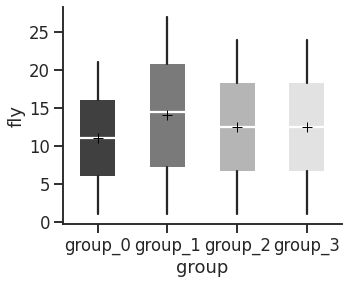

x


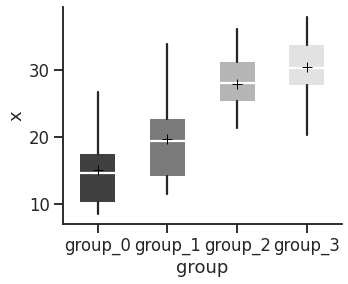

y


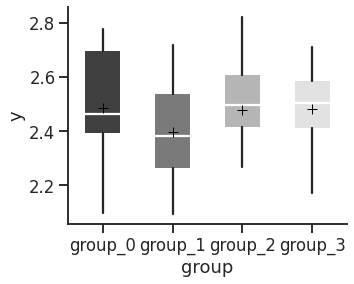

time


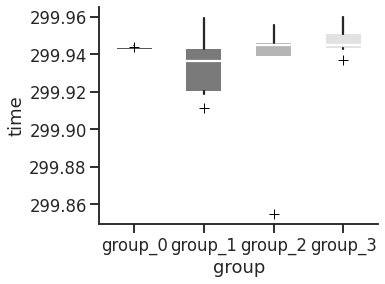

latency


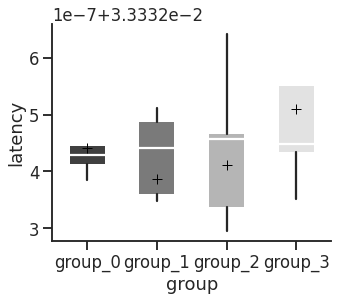

displacement


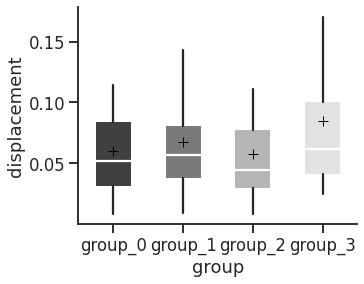

speed


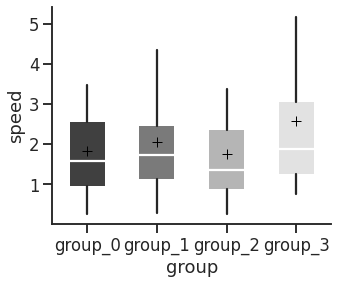

acceleration


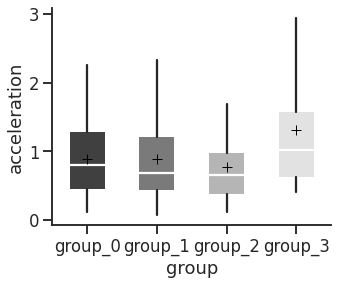

cumul_displacement


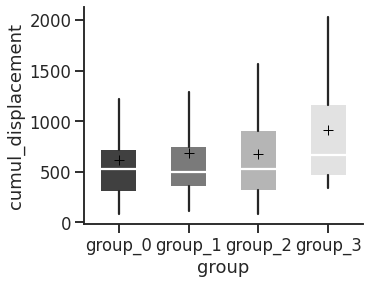

angle


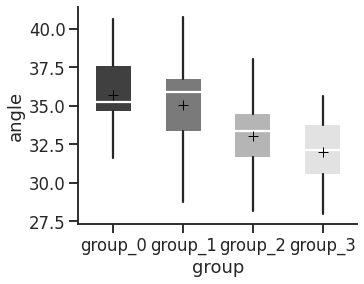

heading


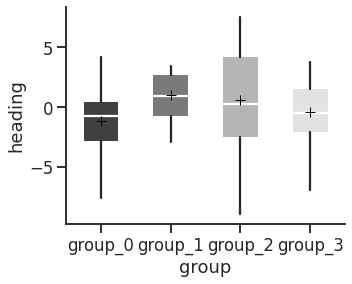

turn_angle


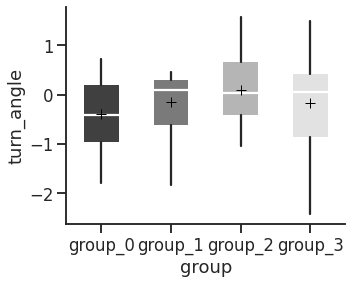

v_x


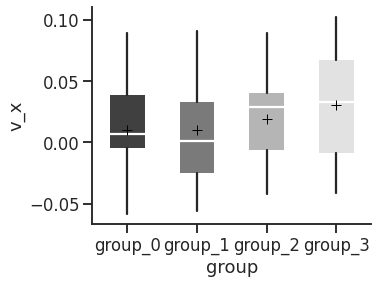

led_state


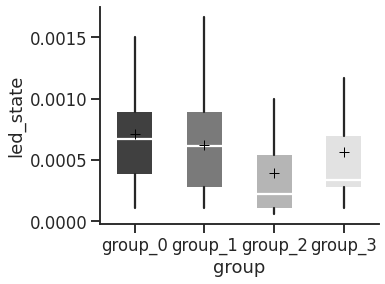

stop


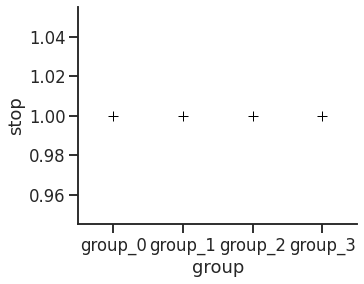

cumsum_led_state


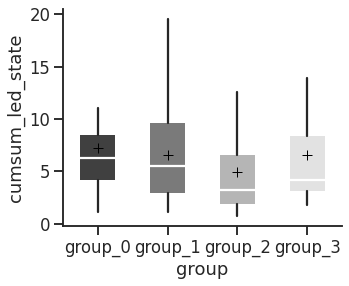

search_bout


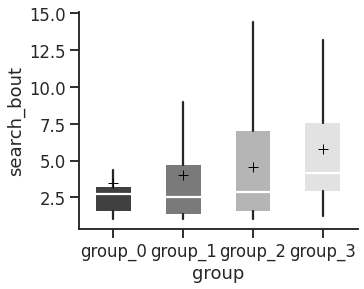

excursion


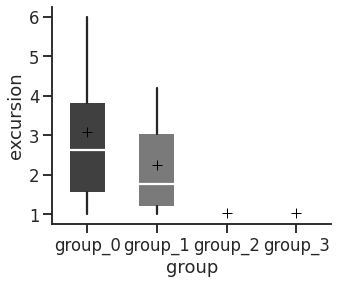

zone


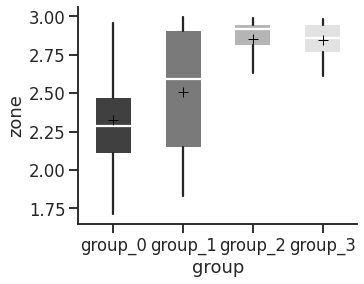

return_binary


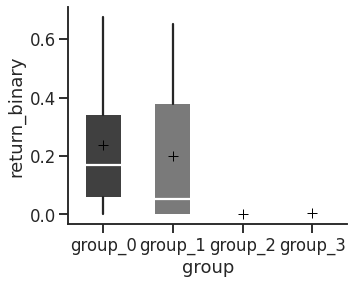

group_time


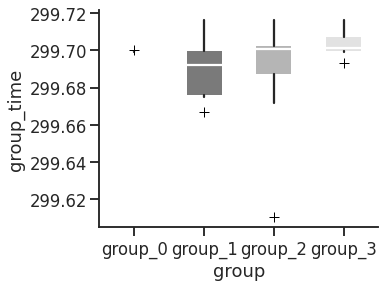

In [ ]:
df4plot = all_df.groupby(['group', 'fly']).mean().reset_index()
y = df4plot.columns
print(y)
sns.set_theme(style="ticks")
sns.set_context("talk")
for i in range(len(y)):
    if df4plot[y[i]].dtype != object:
        fig, ax = plt.subplots(figsize=(5,4))

        sns.boxplot(
                x='group',
                y=y[i],
                hue='group',
                color='k',
                # palette='viridis',
                palette=my_color_palette,
                width=0.5,
                showmeans=True,
                meanprops={"marker":"+",
                           "markeredgecolor":"black",
                           "markersize":"10"},
                showfliers=False,
                # ci=68,
                # scale=0.7,
                dodge=False,
                data=df4plot,
                ax=ax,
                **PROPS
            )

        # sns.pointplot(
        #     x='group',
        #     y=y[i],
        #     hue='group',
        #     color='k',
        #     # ci=68,
        #     # estimator=np.median,
        #     scale=1,
        #     palette=my_color_palette,
        #     capsize=0.2,
        #     dodge=False,
        #     data=df4plot
        # )

        # sns.stripplot(
        #     x='group',
        #     y=y[i],
        #     hue='group',
        #     dodge=False,
        #     palette=my_color_palette,
        #     alpha=0.3,
        #     data=df4plot,
        #     zorder=0,

        # )



        print(y[i])
        plt.legend([],[], frameon=False)
        sns.despine()
        plt.show( )


In [ ]:
# X vs Time (1):
agg_list = []
selected_group = [
                  'group_0', 'group_1', 'group_2', 'group_3'
                #   'group_2', 'group_3'
                #   'group_3', 'group_4', 'group_5',
                #   'group_4', 'group_5',
                #   'group_6',
                #   'group_7',
                #   'group_8', 'group_9',
                #   'group_10', 'group_11'
            ]
for grp in selected_group:
    d = all_df[(all_df.group==grp)]
    d['trials'] = np.nan
    d['time_slice'] = np.nan
    rng_sec = 1
    for i in (d.fly.unique()):
        single_fly = d[(d.fly==i)].copy()
        indices = single_fly[(single_fly.led_state==True)].index.values
        for j, idx in enumerate(indices):
            t_zero = single_fly.iloc[idx].time
            target_idx = single_fly[(single_fly.time >= t_zero - rng_sec) & (single_fly.time <= t_zero + 2*rng_sec)].index.values

            target_df = single_fly.iloc[target_idx]
            target_df.trials = j+1
            target_df.time_slice = target_df.time.values - t_zero
            agg_df = target_df.groupby(pd.cut(target_df.time_slice, np.arange(-rng_sec, 2*rng_sec+0.05, 0.05))).mean().reset_index(drop=True)
            agg_df.time_slice = np.arange(-rng_sec, 2*rng_sec, 0.05)
            agg_df['group'] = grp
            agg_list.append(agg_df[['time_slice', 'fly', 'group', 'trials', 'v_x', 'x', 'speed', 'acceleration', 'turn_angle']])

agg_df = pd.concat(agg_list).reset_index(drop=True)
agg_df = agg_df.dropna()
agg_df.v_x = -1*agg_df.v_x
agg_df.trials = agg_df.trials.astype(int)
agg_df

AttributeError: ignored

In [ ]:
 # X vs Time (2):
early_agg_df = agg_df[agg_df.trials < agg_df.trials.quantile(0.25)]
print(agg_df.trials.quantile(0.25))
early_agg_df['trials_class'] = 'early'
mid_agg_df = agg_df[(agg_df.trials >= agg_df.trials.quantile(0.25)) & (agg_df.trials < agg_df.trials.quantile(0.75))]
mid_agg_df['trials_class'] = 'mid'
print(agg_df.trials.quantile(0.75))
late_agg_df = agg_df[agg_df.trials >= agg_df.trials.quantile(0.75)]
late_agg_df['trials_class'] = 'late'
early_mid_late_df = pd.concat([early_agg_df, mid_agg_df, late_agg_df])


data = agg_df.groupby(['group', 'fly', 'time_slice'], as_index=False).mean()
# data = late_agg_df.groupby(['group', 'fly', 'time_slice'], as_index=False).mean()
# data = mid_agg_df.groupby(['group', 'fly', 'time_slice'], as_index=False).mean()
# data = early_agg_df.groupby(['group', 'fly', 'time_slice'], as_index=False).mean()
# data = early_mid_late_df[(early_mid_late_df.group == 'group_3')]
# data = agg_df[(agg_df.group == 'group_7')]
# data = agg_df
sns.set_theme(style="ticks")
sns.set_context("talk")

f, ax = plt.subplots(figsize=(3, 4))

sns.lineplot(
             x='time_slice',
            #  y="x",
            #  y="acceleration",
            #  y="speed",
             y="v_x",
             hue="group",
            #  hue="trials",
            #  hue='trials_class',
             legend=False,
             ci=68,
            #  estimator=np.median,
             palette=my_color_palette,
             data=data,
             ax=ax)

plt.axvspan(0,0.5, color='k', ec=None, alpha=0.1)
ax.set(
    # ylim=[-5, 15],
    # ylabel='X(mm)',
    ylabel='Velocity(mm/s)',
    xlim=[-1, 2],
    xlabel='Time(s)',
    )

ax.axhline(6, color='k', alpha=0.5, linestyle='--')


ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
sns.despine(trim=True)


fig_title = 'X_vs_Time_NPF2A_CsChr_SEZ3_TNT'
base_path = '/content/drive/My Drive/01_paper/SEZ3/raw_data/' + fig_title
fig_path = base_path + '.svg'

# plt.savefig(fig_path, format='svg', transparent=True, bbox_inches='tight', pad_inches=0.0, dpi=600)
plt.show()

NameError: ignored

In [ ]:
df4plot = all_df.groupby(['group', 'fly', 'search_bout', 'excursion']).max().reset_index()
df4plot.x = 50-df4plot.x
# all_df[(all_df.group=='group_3') & (all_df.fly==32) & (all_df.return_walkaway=='return')].x.plot()
print(df4plot.tail(5))
# df4plot = df4plot[(df4plot.group=='group_3') & (df4plot.fly==31)]

PROPS = {
    'boxprops':{'edgecolor':'none'},
    'medianprops':{'color':'white'},
    # 'whiskerprops':{'color':'blue'},
    'capprops':{'color':'none'}
}

fig, ax = plt.subplots(figsize=(5,4))

# sns.boxplot(
#             x='group',
#             y='x',
#             hue='return_walkaway',
#             # color='k',
#             # palette='viridis',
#             # palette=my_color_palette,
#             width=0.5,
#             showmeans=True,
#             meanprops={"marker":"+",
#                     "markeredgecolor":"black",
#                     "markersize":"10"},
#             showfliers=False,
#             # ci=68,
#             # scale=0.7,
#             dodge=True,
#             data=df4plot,
#             ax=ax,
#             **PROPS
#             )

sns.stripplot(
    x='group',
    y='x',
    hue='return_walkaway',
    hue_order=['walkaway', 'return'],
    dodge=True,
    alpha=0.2,
    ax= ax,
    # data=df4plot[df4plot['return_walkaway'] == 'return']
    data=df4plot,

)
ax.axhline(44, color='k', alpha=0.5, linestyle='--')
ax.axhline(41, color='k', alpha=0.5, linestyle='--')
ax.axhline(6, color='k', alpha=0.5, linestyle='--')

ax.set(
    ylabel='Major turning point(mm)',
    ylim=[0, 50]
)
ax.get_legend().remove()
sns.despine(trim=True)

fig_title = 'major_turn_SEZ3_GrACR1'
base_path = '/content/drive/My Drive/01_paper/SEZ3/raw_data/' + fig_title
fig_path = base_path + '.svg'

plt.savefig(fig_path, format='svg', transparent=True, bbox_inches='tight', pad_inches=0.0, dpi=600)
plt.show()


AttributeError: ignored

NameError: ignored

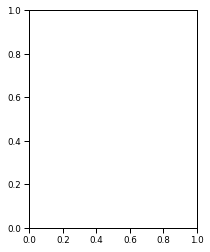

In [ ]:
PROPS = {
    'boxprops':{'edgecolor':'none'},
    'medianprops':{'color':'white'},
    # 'whiskerprops':{'color':'blue'},
    'capprops':{'color':'none'}
}

fig, ax = plt.subplots(figsize=(3,4))

sns.boxplot(
            x='group',
            y='x',
            # hue='return_walkaway',
            # color='k',
            # palette='viridis',
            palette=my_color_palette,
            width=0.5,
            showmeans=True,
            meanprops={"marker":"+",
                    "markeredgecolor":"black",
                    "markersize":"10"},
            showfliers=False,
            # ci=68,
            # scale=0.7,
            dodge=True,
            data=df4plot[df4plot.return_walkaway=='return'],
            ax=ax,
            **PROPS
            )
plt.legend([],[], frameon=False)
sns.despine()

ax.set(
    ylabel='Major turning point(mm)',
    ylim=[0, 50]
)

fig_title = 'major_return' + '_SEZ3_GrACR1'
base_path = '/content/drive/My Drive/01_paper/SEZ3/raw_data/' + fig_title
fig_path = base_path + '.svg'

plt.savefig(fig_path, format='svg' , transparent=True, bbox_inches='tight', pad_inches=0.0, dpi=600)
plt.show()

In [ ]:
df4plot

df_wide=pd.pivot(df4plot,
                 index=['return_walkaway', 'fly', 'search_bout', 'excursion'],
                 columns ='group' ,values = 'x')
fname = 'major_turn' + '_SEZ3_GrACR1.csv'
df_wide.to_csv('/content/drive/My Drive/01_paper/SEZ3/raw_data/' + fname)

df_wide

NameError: ignored

In [ ]:
all_df.columns
all_df[(all_df.group=='group_0') & (all_df.fly==1) & (all_df.return_walkaway=='walkaway') & (all_df.stop==1)& (all_df.search_bout==7)& (all_df.excursion==1) ]

In [ ]:
sns.set_context('talk')
label = False
# for i in all_df.group.unique():
#     for j in all_df[all_df.group==i].fly.unique():
#         for k in all_df[(all_df.group==i) & (all_df.fly==j)].search_bout.unique():
traj = all_df[(all_df.group=='group_0') & (all_df.fly==1) & (all_df.search_bout==7)& (all_df.excursion==1) & (all_df.return_walkaway=='walkaway')]
traj['time_0'] = traj.time - traj.time.values[0]
print(traj[traj.index <=7582])
f, ax = plt.subplots()
sns.scatterplot(data=traj[traj.index <=7582], x='x', y='y', palette='viridis', edgecolor=None,
                hue='time_0',
                alpha=0.5, s=15, legend=False)

ax.tick_params(bottom=False, left=False)
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_aspect('equal')
ax.set_ylim([0, 5])
ax.set_xlim([0, 50])
ax.axvline(6, color='k', ls=':', alpha=0.5)
ax.axvline(9, color='k', ls=':', alpha=0.5)
ax.axvline(44, color='k', ls=':', alpha=0.5)
# ax.axvline(41, color='k', ls=':', alpha=0.5)
if label == False:
    ax.set_xticklabels([])
    ax.set_xlabel(None)
    ax.set_yticklabels([])
    ax.set_ylabel(None)


fig_title = 'traj_major_stop' + '_Gr64f_CsChrimson'
base_path = '/content/drive/My Drive/01_paper/SEZ3/raw_data/' + fig_title
fig_path = base_path + '.svg'
plt.savefig(fig_path, format='svg' , transparent=True, bbox_inches='tight', pad_inches=0.0, dpi=600)
plt.show()

In [ ]:
bin = 10
all_df['binned_time'] = all_df['time'].values // 60
df4plot = all_df.groupby(['group', 'fly', 'binned_time']).mean().reset_index()
print(df4plot.head())
fig, ax = plt.subplots()
sns.lineplot(
    x= 'binned_time',
    # y= 'speed',
    y= 'led_state',
    hue='group',
    ci=68,
    palette=my_color_palette,
    # legend=False,
    data=df4plot
)
sns.despine()
ax.set(xlim=[0, 10])

TypeError: ignored

In [ ]:
df4plot = all_df[(all_df['return_walkaway']=='return') & (all_df['x'] <=6)].groupby(['group', 'fly']).sum().reset_index()
print(df4plot.head())
fig, ax = plt.subplots()
sns.stripplot(
    x='group',
    y='latency',
    # y='displacement',
    # hue='group',
    alpha=0.2,
    # legend=False,
    ax= ax,
    # data=df4plot[df4plot['return_walkaway'] == 'return']
    data=df4plot
)
sns.pointplot(
    x='group',
    y='latency',
    # y='displacement',
    # hue='group',
    alpha=0.2,
    ax= ax,
    join=False,
    # data=df4plot[df4plot['return_walkaway'] == 'return']
    data=df4plot
)
ax.set(
    # ylim=[0, 50]
)

In [ ]:
# rw_df = all_df[(all_df.group=='group_0')]
# rw_arr = all_df[(all_df.group=='group_0')].return_walkaway.values
# rw_arr = np.where(rw_arr=='return', 1, 0)
# rw_df['rw_binary'] = rw_arr

# plt.hist2d(data=rw_df, x='time', y='rw_binary',
#            bins=[30, 25], range=[[0, 600], [0, 15]],
#                density=True,
#             #    norm=mpl.colors.LogNorm(),
#                cmap='magma')

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


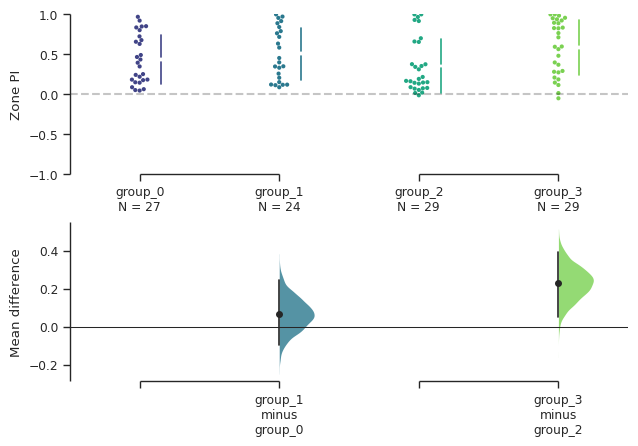

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


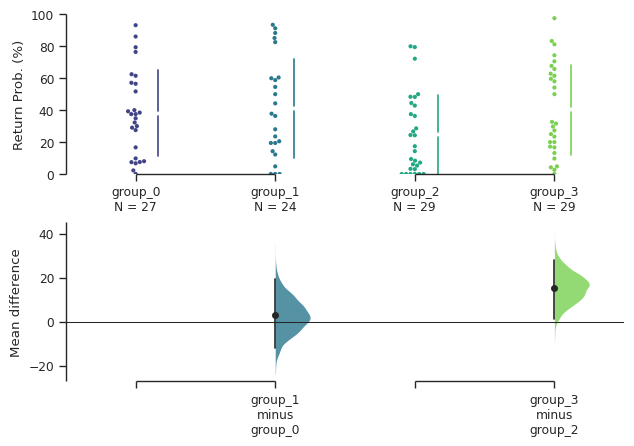

In [ ]:
 # sns.set_style("ticks")
sns.set_context("paper")
grey = (0.5, 0.5, 0.5)
num_color = 4
plot_list = ['zone_pi', 'return_prob']
np.random.seed(42)
# plot_list = [zone_pi_df, return_prob_df]
for i, d in enumerate(plot_list):
    if i == 0:
        y_target = d
        y_label = 'Zone PI'
        s_ylim = (-1, 1)
        c_ylim = (-1, 1)
        s_mj_loc = 1
        c_mj_loc = 1
        c = 'crest_r'
        # c_test = 'Greys_r'
    else:
        y_target = d
        y_label = 'Return Prob. (%)'
        s_ylim = (0, 100)
        c_ylim = (-50, 50)
        s_mj_loc = 50
        c_mj_loc = 50
        c = 'flare_r'

    # elif i == 2:
    #     y_target = d
    #     y_label = 'Search distance (mm)'
    #     s_ylim = (35, 150)
    #     c_ylim = (-25, 25)
    #     s_mj_loc = 100
    #     c_mj_loc = 50
    #     c = 'viridis'

    palette_test = sns.color_palette('crest_r', num_color)
    palette_test = sns.color_palette('viridis', num_color)
    palette_control = sns.color_palette('flare_r', num_color)

    # s_mj_loc = s_ylim[1]
    # c_mj_loc = c_ylim[1]

    my_color_palette = {'group_0': palette_test[0],
                        'group_1': palette_test[1],
                        'group_2': palette_test[2],
                        'group_3': palette_test[3],
                        # 'group_4': palette_test[4],
                        # 'group_5': palette_test[5],
                        # 'group_6': palette_test[6],
                        # 'group_7': palette_test[7],
                        # 'group_8': palette_test[8],
                        # 'group_9': palette_test[9],
                        # 'group_10': palette_test[10],
                        # 'group_11': palette_test[11],
                        # 'group_12': palette_test[12],
                        # 'group_13': palette_test[13],
                        # 'group_14': palette_test[14],
                        # 'group_15': palette_test[15],
                        # 'group_16': palette_test[16],
                        # 'group_17': palette_test[17],
                        # 'group_18': palette_test[18],
                        # 'group_19': palette_test[19],
                        # 'group_20': palette_test[20],
                        # 'group_21': palette_test[21],
                        # 'group_22': palette_test[22],
                        # 'group_23': palette_test[23],
                        # 'group_24': palette_test[24],
                        # 'group_25': palette_test[25],
                        # 'group_26': palette_test[26],
                        # 'group_27': palette_test[27],
                        # 'group_28': palette_test[28],
                        # 'group_29': palette_test[29],
                        # 'group_30': palette_test[30],
                        # 'group_31': palette_test[31],
                        # 'group_32': palette_test[32],
                        # 'group_33': palette_test[33],
                        # 'group_34': palette_test[34],
                        # 'group_35': palette_test[35],
                        # 'group_36': palette_test[36],
                        # 'group_37': palette_test[37],
                        # 'group_38': palette_test[38],
                        # 'group_39': palette_test[39],
                        # 'group_40': palette_test[40],
                        }

    multi_groups = dabest.load(zone_return_df,
                            x="group", y=y_target,

                            idx=(
                                 ('group_0', 'group_1',) ,
                                 ('group_2', 'group_3',)
                                #  ('group_5', 'group_6', 'group_7', 'group_8', 'group_9'),
                                #  ('group_10', 'group_11'),
                                #  ('group_12', 'group_13'),
                                #  ('group_14', 'group_15', 'group_16', 'group_17'),
                                #  ('group_18', 'group_19', 'group_20', 'group_21'),
                                #  ('group_22', 'group_23'),
                                #  ('group_24', 'group_25'),

                                 ))

    # multi_groups = dabest.load(zone_return_df,
    #                         x="group", y=y_target,
    #                         idx=(('group_0', 'group_1', 'group_2', 'group_3'),
    #                              ('group_4', 'group_5', 'group_6','group_7'),
    #                              ('group_8', 'group_9', 'group_10','group_11'),
    #                              ('group_12','group_13', 'group_14','group_15', 'group_16'),
    #                              ('group_17', 'group_18'),
    #                              ('group_19', 'group_20'),
    #                              ('group_21', 'group_22'),
    #                              ('group_23', 'group_24'),
    #                              ('group_25', 'group_26'),
    #                              ('group_27', 'group_28'),
    #                              ('group_29', 'group_30'),
    #                              ('group_31', 'group_32')
    #                              ))
    # 215.9, 279.4
    single_width = 89 / 25.4
    single_half_width = 136 / 25.4
    double_width = 183 /25.4
    # double_width = 215.9 /25.4


    depth = 247 / 25.4
    # depth = 279.4 / 25.4
    # num_rows = 4
    num_rows = 2
    # num_col = 2
    num_col = 1

    height = depth/num_rows
    width = double_width/num_col

    f = multi_groups.mean_diff.plot(swarm_label=y_label,
                                raw_marker_size=3,
                                es_marker_size=4,
                                custom_palette=my_color_palette,
                                fig_size=(width, height), # W X H
                                group_summary_kwargs = {'lw':1.2},
                                swarm_desat=1,
                                swarm_ylim = s_ylim,
                                # contrast_ylim = c_ylim,
                                );

    rawswarm_axes = f.axes[0]
    contrast_axes = f.axes[1]

    if i == 0:
        rawswarm_axes.axhline(0, color='k', alpha=0.25, ls='--', lw=1.5)

    # rawswarm_axes.yaxis.set_major_locator(ticker.MultipleLocator(s_mj_loc))
    # contrast_axes.yaxis.set_major_locator(ticker.MultipleLocator(c_mj_loc))
    fig_title = 'SEZ3_500ms_'
    base_path = '/content/drive/My Drive/00_project/05_fly-arena/5_LocalSearch/0_LinearChamber/figures/sez3/' + fig_title
    stat_path = base_path + d + '_statistics.csv'
    fig_path = base_path + d + '.svg'

    # multi_groups.mean_diff.statistical_tests.to_csv(stat_path)

    # plt.savefig(fig_path, format='svg' , transparent=True, bbox_inches='tight', pad_inches=0.0, dpi=600)

    plt.show()


In [ ]:
all_df.columns

Index(['time', 'latency', 'x', 'y', 'led_state', 'fly', 'group', 'cumsum_dist',
       'v_x', 'v_y', 'speed', 'h_x', 'h_y', 'turn_rate', 'stop', 'search_bout',
       'return_walkaway', 'excursion', 'zone'],
      dtype='object')

In [ ]:
# fly_num = 8
# all_df[(all_df.group=='group_0') & (all_df.fly==fly_num)][:7500].x.plot()
# all_df[(all_df.group=='group_0') & (all_df.fly==fly_num)][:7500].search_bout.plot()
# all_df[(all_df.group=='group_0') & (all_df.fly==fly_num)][:7500].stop.plot()

In [ ]:
zone_return_df[zone_return_df.group=='group_3']

,group,fly,zone_pi,return_prob
45,group_3,1,0.577345,17.857143
46,group_3,2,0.771209,36.363636
47,group_3,3,0.360170,37.837838
48,group_3,4,0.692004,0.000000
49,group_3,5,0.563829,12.903226
50,group_3,6,0.723290,44.444444
51,group_3,7,0.795103,62.500000
52,group_3,8,1.000000,92.857143
53,group_3,9,0.466961,30.769231
54,group_3,10,0.620924,0.000000


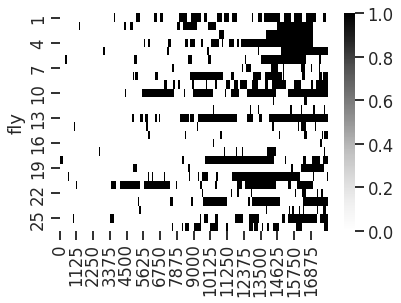

In [ ]:
test_df = all_df[all_df.group == 'group_11'][['fly', 'stop', 'led_state', 'time']]
test_df['led_state'] = test_df['led_state'].astype(int)

piv = pd.pivot_table(test_df, values="stop",index=["fly"], columns=test_df.index)

piv
ax = sns.heatmap(piv, cmap='Greys', )

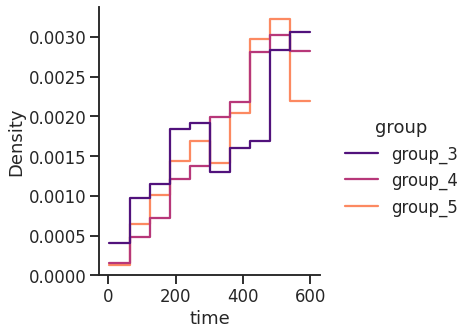

In [ ]:
sns.set_style("ticks")
sns.set_context("talk")

plot_df = all_df[(all_df.stop==1) & ((all_df.group=='group_3') | (all_df.group=='group_4') | (all_df.group=='group_5'))].reset_index()
sns.displot(data=plot_df, x='time', kind='hist', palette='magma',
            hue='group', element="step", bins=10,
            # cumulative=True,
            common_norm=False,
            fill=False,
            stat='density')

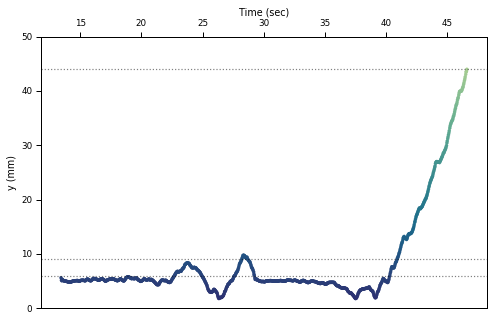

In [ ]:
input = all_df[(all_df.group=='group_0') & (all_df.fly==5) & (all_df.search_bout==1)]

f, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(data=input, x="time", y="x", hue='x', palette='crest_r', s=10, ax=ax, legend=False, edgecolor=None)
# ax.tick_params(bottom=False, left=False)
ax.set_xlabel('Time (sec)')
ax.set_ylabel('y (mm)')
ax.set_ylim([0, 50])
# ax.set_xlim([0, 50])
# ax.set_yticks([0, 300, 600])
# ax.set_xticks([0, 25, 50])
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
# ax.invert_yaxis()
ax.axhline(6, color='k', ls=':', alpha=0.5)
ax.axhline(9, color='k', ls=':', alpha=0.5)
ax.axhline(44, color='k', ls=':', alpha=0.5)
# ax.axhline(41, color='k', ls=':', alpha=0.5)
# if label == False:
#     ax.set_xticklabels([])
#     ax.set_xlabel(None)
#     ax.set_yticklabels([])
#     ax.set_ylabel(None)

fig_title = 'example_return_travel_Gr64f_CsChrimson'
base_path = '/content/drive/My Drive/01_paper/SEZ3/raw_data/' + fig_title
fig_path = base_path + '.svg'

plt.savefig(fig_path, format='svg' , transparent=True, bbox_inches='tight', pad_inches=0.0, dpi=600)

plt.show()

In [ ]:
_df = all_df[(all_df.group=='group_0') & (all_df.fly==1) & (all_df.search_bout==1)]
led_true = _df.led_state.values
slc_idx = np.argwhere(led_true==True).reshape(-1)

for i, v in enumerate(slc_idx):
    if i < len(slc_idx)-1:
        output = _df.iloc[slc_idx[i]:slc_idx[i+1]]
    else:
        output = _df.iloc[slc_idx[i]:]
    print(output)

         time   latency         x  ...  search_bout  zone    group
101  3.363433  0.033103  5.211458  ...          1.0   1.0  group_0
102  3.396838  0.033405  4.400267  ...          1.0   1.0  group_0
103  3.430116  0.033278  3.360735  ...          1.0   1.0  group_0
104  3.463416  0.033301  2.276692  ...          1.0   1.0  group_0
105  3.497108  0.033692  1.445408  ...          1.0   1.0  group_0
..        ...       ...       ...  ...          ...   ...      ...
188  6.263428  0.033346  9.599088  ...          1.0   3.0  group_0
189  6.297142  0.033714  8.894889  ...          1.0   NaN  group_0
190  6.330137  0.032996  8.068773  ...          1.0   NaN  group_0
191  6.363743  0.033605  7.290593  ...          1.0   NaN  group_0
192  6.396965  0.033223  6.542171  ...          1.0   NaN  group_0

[92 rows x 17 columns]
          time   latency         x  ...  search_bout  zone    group
193   6.430166  0.033201  5.689259  ...          1.0   1.0  group_0
194   6.463460  0.033294  4.800856  

In [ ]:
# fly_num = 13
# num_search = all_df[(all_df.group=='group_0') & (all_df.fly==fly_num)].search_bout.unique()[-1]
# num_activation = all_df[(all_df.group=='group_0') & (all_df.fly==fly_num)].led_state.sum()
# print(num_search, num_activation)

In [ ]:
# test_df = pd.DataFrame(search_dist, columns=['cent_mass_x', 'cent_mass_y', 'search_dist', 'revisits', 'search_bout', 'fly', 'group'])

# group_df = test_df.groupby(['group','fly']).mean().reset_index()
# sns.swarmplot(data=group_df, x="group", y="revisits", hue="group")

In [ ]:
node_list = []
occu_list = []
zone_target_list = []
for j in all_df.group.unique():
    for i in all_df[all_df.group==j].fly.unique():
        z1_occu = all_df[(all_df.group==j) & (all_df.fly==i) & (all_df.zone == 1)].copy().latency.sum()
        z2_occu = all_df[(all_df.group==j) & (all_df.fly==i) & (all_df.zone == 2)].copy().latency.sum()
        z1_occu_norm = z1_occu / (z1_occu + z2_occu)
        z2_occu_norm = z2_occu / (z1_occu + z2_occu)
        pi = (z1_occu - z2_occu) / (z1_occu + z2_occu)
        occu_list.append([z1_occu_norm, z2_occu_norm, pi, j, i])

        z_df = all_df[(all_df.group==j) & (all_df.fly==i)]
        drop_reset_zone = z_df.loc[:, z_df.columns != 'search_bout' ].copy().dropna()
        zone_change = drop_reset_zone[drop_reset_zone.zone.shift() != drop_reset_zone.zone].copy()
        zone_change = zone_change.drop(zone_change[zone_change.zone==3].index)
        zone_change['from'] = zone_change.zone
        zone_change['to'] = zone_change.zone.shift(-1)
        zone_change.dropna(inplace=True)
        z1toz2 = ((zone_change['from']==1) & (zone_change['to']==2)).sum()/total_events
        z2toz1 = ((zone_change['from']==2) & (zone_change['to']==1)).sum()/total_events
        z1toz1 = ((zone_change['from']==1) & (zone_change['to']==1)).sum()/total_events
        z2toz2 = ((zone_change['from']==2) & (zone_change['to']==2)).sum()/total_events
        node_list.append(zone_change[['time', 'fly', 'group', 'from', 'to']])
        zone_target_list.append([z1toz2, z2toz1, z1toz1, z2toz2, j, i])


zone_df = pd.DataFrame(occu_list, columns=['z1_occu_norm', 'z2_occu_norm', 'zone_pi', 'group', 'fly'])
event_df = pd.DataFrame(zone_target_list, columns=['z1toz2', 'z2toz1', 'z1toz1', 'z2toz2', 'group', 'fly'])
event_df['return_prob'] = event_df['z1toz1'] / (event_df['z1toz1'] + event_df['z1toz2']) * 100
node_df = pd.concat(node_list)
whole_list = [zone_df, event_df, node_df]
# for i in range(3):
#     frame_list = ['zone_df', 'event_df', 'node_df']
#     save_csv_path = base_dir + 'output/' + frame_list[i] + '.csv'
#     final = whole_list[i]
#     final.to_csv(save_csv_path, index=False)
#     print('File saved:' + save_csv_path)


print('event')
print(event_df)
print('zone')
print(zone_df)
print(node_df)

event
       z1toz2    z2toz1    z1toz1    z2toz2    group  fly  return_prob
0    0.200000  0.200000  1.533333  0.000000  group_0    1    88.461538
1    0.066667  0.066667  1.200000  0.000000  group_0    2    94.736842
2    0.600000  0.600000  0.666667  0.000000  group_0    3    52.631579
3    0.400000  0.400000  1.200000  0.000000  group_0    4    75.000000
4    0.466667  0.466667  0.866667  0.000000  group_0    5    65.000000
..        ...       ...       ...       ...      ...  ...          ...
109  0.133333  0.066667  0.133333  0.066667  group_7   11    50.000000
110  0.133333  0.133333  0.200000  0.200000  group_7   12    60.000000
111  0.666667  0.666667  0.133333  0.133333  group_7   13    16.666667
112  0.333333  0.333333  0.600000  0.066667  group_7   14    64.285714
113  0.333333  0.333333  0.533333  0.066667  group_7   15    61.538462

[114 rows x 7 columns]
zone
     z1_occu_norm  z2_occu_norm   zone_pi    group  fly
0        0.978876      0.021124  0.957752  group_0    1
1

In [ ]:
return_bout_list = []
for j in node_df.group.unique():
    for i in node_df[node_df.group==j].fly.unique():
        fly_num = i
        # select trials in a experiment of single fly of a group.
        ext = node_df[(node_df.fly ==fly_num) & (node_df.group ==j)].copy().reset_index()
        slcs = []
        for k in ext.index.values:
            # only takes returning events: 'from zone 1 to zone 1'
            if (ext.loc[k]['from'] != ext.loc[k]['to']) | (ext.loc[k]['from'] ==2.0) | (ext.loc[k]['to'] ==2.0):
                pass
            else:
                init_idx = int(ext.loc[k]['index'])
                if k == ext.index.values[-1]:
                    last_idx = int(all_df[(all_df.fly ==fly_num) & (all_df.group ==j)].copy().index.values[-1])
                    slcs.append(slice(init_idx, last_idx))
                else:
                    last_idx = int(ext.loc[k+1]['index'])
                    slcs.append(slice(init_idx, last_idx))

        for l, slc in enumerate(slcs):
            slc_df = all_df[(all_df.fly ==fly_num) & (all_df.group ==j)].copy()[slc]
            slc_df['bout'] = l+1
            slc_df['time_0'] = slc_df.time.values - slc_df.time.values[0]
            return_bout_list.append(slc_df)

return_bouts = pd.concat(return_bout_list)
return_bouts.tail()

,time,latency,x,y,led_state,fly,cumsum_dist,v_x,v_y,speed,h_x,h_y,stop,turn_rate,search_bout,excursion,zone,group,bout,time_0
17990,599.684998,0.033502,6.995255,1.898059,False,15,1439.243786,-0.186281,0.419919,0.459383,-0.405502,0.914094,0,159.153766,6.0,14.0,NaN,group_7,8,76.036264
17991,599.717561,0.032562,6.989056,1.913744,False,15,1439.260652,-0.190376,0.481713,0.517968,-0.367545,0.930006,0,2.358322,6.0,14.0,NaN,group_7,8,76.068826
17992,599.751683,0.034123,6.972810,1.927545,False,15,1439.281968,-0.476088,0.404451,0.624693,-0.762116,0.647440,0,28.086842,6.0,14.0,NaN,group_7,8,76.102948
17993,599.784848,0.033164,6.951847,1.938784,False,15,1439.305754,-0.632090,0.338883,0.717203,-0.881327,0.472507,0,12.151765,6.0,14.0,NaN,group_7,8,76.136113
17994,599.818933,0.034085,6.918292,1.958952,False,15,1439.344904,-0.984467,0.591699,1.148600,-0.857101,0.515148,0,2.810203,6.0,14.0,NaN,group_7,8,76.170198


In [ ]:
# return_bouts[(return_bouts.fly == 18) & (return_bouts.group == 'group_3')].speed.plot(kind='hist')

In [ ]:
# def apply_hysteresis_threshold(image, low, high):
#     """Apply hysteresis thresholding to ``image``.
#     This algorithm finds regions where ``image`` is greater than ``high``
#     OR ``image`` is greater than ``low`` *and* that region is connected to
#     a region greater than ``high``.
#     Parameters
#     ----------
#     image : array, shape (M,[ N, ..., P])
#         Grayscale input image.
#     low : float, or array of same shape as ``image``
#         Lower threshold.
#     high : float, or array of same shape as ``image``
#         Higher threshold.
#     Returns
#     -------
#     thresholded : array of bool, same shape as ``image``
#         Array in which ``True`` indicates the locations where ``image``
#         was above the hysteresis threshold.
#     Examples
#     --------
#     >>> image = np.array([1, 2, 3, 2, 1, 2, 1, 3, 2])
#     >>> apply_hysteresis_threshold(image, 1.5, 2.5).astype(int)
#     array([0, 1, 1, 1, 0, 0, 0, 1, 1])
#     References
#     ----------
#     .. [1] J. Canny. A computational approach to edge detection.
#            IEEE Transactions on Pattern Analysis and Machine Intelligence.
#            1986; vol. 8, pp.679-698.
#            :DOI:`10.1109/TPAMI.1986.4767851`
#     """
#     low = np.clip(low, a_min=None, a_max=high)  # ensure low always below high
#     mask_low = image > low
#     mask_high = image > high
#     # Connected components of mask_low
#     labels_low, num_labels = ndi.label(mask_low)
#     # Check which connected components contain pixels from mask_high
#     sums = ndi.sum(mask_high, labels_low, np.arange(num_labels + 1))
#     connected_to_high = sums > 0
#     thresholded = connected_to_high[labels_low]

#     # # Connected components of mask_low
#     # labels_high, num_labels = ndi.label(mask_low)
#     # # Check which connected components contain pixels from mask_high
#     # sums = ndi.sum(mask_low, labels_high, np.arange(num_labels + 1))
#     # connected_to_low = sums > 0
#     # thresholded = connected_to_low[labels_high]

#     return thresholded

In [ ]:
# signal = all_df[(all_df.group=='group_0') & (all_df.fly==1)]
# top_band = 44
# bottom_band = 6
# mark_low = signal.x.values < 6
# mark_high = signal.x.values < 44
# low_idx = np.argwhere(np.diff(mark_low.astype(int))==1)
# high_idx = np.argwhere(np.diff(mark_high.astype(int))==-1)
# print(low_idx.reshape(-1))
# print(high_idx.reshape(-1))

# x = signal[10190:11400].x.values
# # final = apply_hysteresis_threshold(signal, 6, 44).astype(int)
# plt.plot(x/50)
# # plt.plot((signal/50))
# # plt.plot((mask_high |mask_low).astype(int))
# # plt.plot(arr[:1200])
# plt.axhline(0.12, c='r')
# plt.axhline(0.18, c='b')
# plt.axhline(0.88, c='g')

In [ ]:
return_bouts.x.max()
maj_turn_list = []
for j in return_bouts.group.unique():
    for i in return_bouts[return_bouts.group==j].fly.unique():
        for k in return_bouts[(return_bouts.fly ==i) & (return_bouts.group ==j)].bout.unique():
            ext = return_bouts[(return_bouts.fly ==i) & (return_bouts.group ==j) & (return_bouts.bout ==k)].copy().reset_index()

            maj_turn_list.append([ext.x.max(), ext[ext.x == ext.x.max()].time_0.values[0], j, i, k])
maj_turn_df = pd.DataFrame(maj_turn_list, columns = ['maj_turns', 't_turns', 'group', 'fly', 'bout'])
maj_turn_df = maj_turn_df.groupby(['group', 'fly']).mean().reset_index().copy()
maj_turn_df.tail()

,group,fly,maj_turns,t_turns,bout
92,group_7,11,11.599090,141.236887,1.5
93,group_7,12,16.049219,16.311773,2.0
94,group_7,13,12.505579,27.001206,1.5
95,group_7,14,10.807745,22.885407,5.0
96,group_7,15,21.098129,36.005378,4.5


In [ ]:
groups

{'group_0_0': '01_Search-Bar_{Gr5alxA}{y};{20G06AD}{U-TNT};{VT055404DBD}{CsChr-mch}_male_starved_mated_Retinal-2021-12-17T11_00_39.csv',
 'group_0_1': '02_Search-Bar_{Gr5alxA}{y};{20G06AD}{U-TNT};{VT055404DBD}{CsChr-mch}_male_starved_mated_Retinal-2021-12-17T11_24_02.csv',
 'group_0_10': '14_Search_{Gr5alxA}{y};{20G06AD}{U-TNT};{VT055404DBD}{CsChr-mch}_male_starved_mated-2022-01-15T10_13_33.csv',
 'group_0_11': '15_Search_{Gr5alxA}{y};{20G06AD}{U-TNT};{VT055404DBD}{CsChr-mch}_male_starved_mated-2022-01-15T10_25_24.csv',
 'group_0_12': '16_Search_{Gr5alxA}{y};{20G06AD}{U-TNT};{VT055404DBD}{CsChr-mch}_male_starved_mated-2022-01-15T10_36_46.csv',
 'group_0_13': '17_Search_{Gr5alxA}{y};{20G06AD}{U-TNT};{VT055404DBD}{CsChr-mch}_male_starved_mated-2022-01-15T10_48_08.csv',
 'group_0_14': '19_Search_{Gr5alxA}{y};{20G06AD}{U-TNT};{VT055404DBD}{CsChr-mch}_male_starved_mated-2022-01-20T10_54_48.csv',
 'group_0_15': '19_Search_{Gr5alxA}{y};{20G06AD}{U-TNT};{VT055404DBD}{CsChr-mch}_male_starved_ma

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


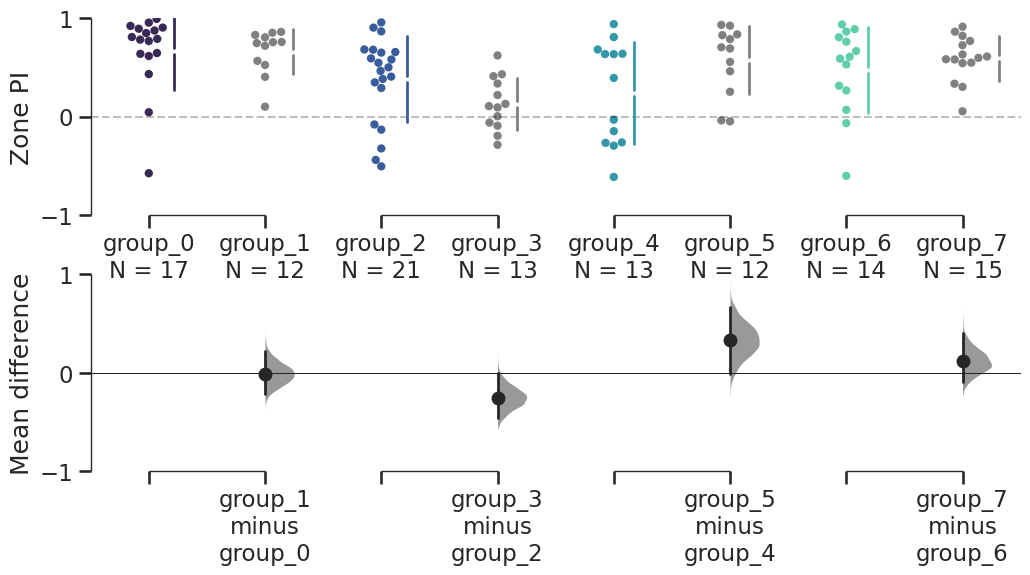

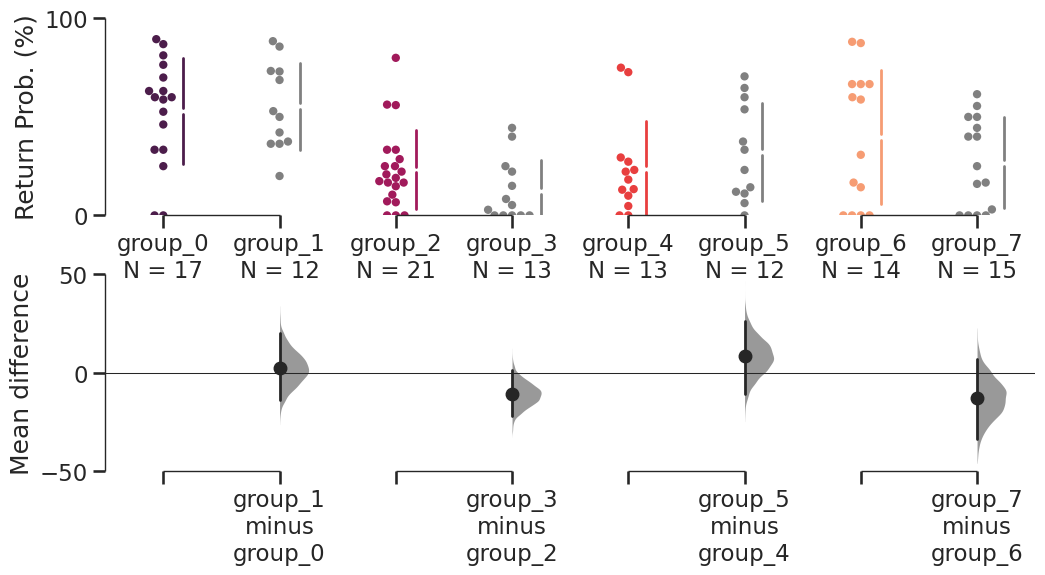

In [ ]:
sns.set_style("ticks")
sns.set_context("talk")
grey = (0.5, 0.5, 0.5)
num_color = 4
# plot_list = [zone_df, event_df]
plot_list = [zone_pi_df, return_prob_df]
for i, d in enumerate(plot_list):
    if i == 0:
        y_target = 'zone_pi'
        y_label = 'Zone PI'
        s_ylim = (-1, 1)
        c_ylim = (-1, 1)
        s_mj_loc = 1
        c_mj_loc = 1
        c = 'mako'
    else:
        y_target = 'return_prob'
        y_label = 'Return Prob. (%)'
        s_ylim = (0, 100)
        c_ylim = (-50, 50)
        s_mj_loc = 100
        c_mj_loc = 50
        c = 'rocket'

    palette = sns.color_palette(c, num_color)

    s_mj_loc = s_ylim[1]
    c_mj_loc = c_ylim[1]

    my_color_palette = {'group_0': palette[0],
                        'group_1': grey,
                        'group_2': palette[1],
                        'group_3': grey,
                        'group_4': palette[2],
                        'group_5': grey,
                        'group_6': palette[3],
                        'group_7': grey,
                        }

    multi_groups = dabest.load(d,
                            x="group", y=y_target,
                            idx=(('group_0','group_1'),
                                 ('group_2','group_3'),
                                 ('group_4','group_5'),
                                 ('group_6','group_7'),))

    # my_color_palette = {'group_0': palette[0],
    #                     'group_1': palette[1],
    #                     'group_2': palette[2],
    #                     'group_3': palette[3],
    #                     }

    # multi_groups = dabest.load(d,
    #                         x="group", y=y_target,
    #                         idx=(('group_0', 'group_1', 'group_2', 'group_3')))


    multi_groups.mean_diff

    f = multi_groups.mean_diff.plot(swarm_label=y_label,
                                    custom_palette=my_color_palette,
                                    swarm_desat=1,
                                    swarm_ylim = s_ylim,
                                    contrast_ylim = c_ylim,);

    rawswarm_axes = f.axes[0]
    contrast_axes = f.axes[1]

    if i == 0:
        rawswarm_axes.axhline(0, color='k', alpha=0.25, ls='--', lw=1.5)

    rawswarm_axes.yaxis.set_major_locator(ticker.MultipleLocator(s_mj_loc))
    contrast_axes.yaxis.set_major_locator(ticker.MultipleLocator(c_mj_loc))


        index        time   latency  ...  return_walkaway  excursion  zone
0        2866   95.533399  0.033343  ...           return        5.0   NaN
1        2867   95.566684  0.033285  ...           return        5.0   NaN
2        2868   95.599928  0.033244  ...           return        5.0   NaN
3        2869   95.632754  0.032826  ...           return        5.0   NaN
4        2870   95.667386  0.034631  ...           return        5.0   NaN
...       ...         ...       ...  ...              ...        ...   ...
347540  17117  570.584068  0.033951  ...        walk-away        1.0   1.0
347541  17118  570.617349  0.033281  ...        walk-away        1.0   1.0
347542  17119  570.650161  0.032812  ...        walk-away        1.0   1.0
347543  17120  570.684081  0.033920  ...        walk-away        1.0   1.0
347544  17121  570.717527  0.033446  ...        walk-away        1.0   1.0

[347545 rows x 20 columns]


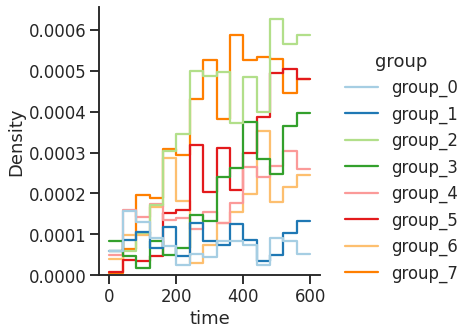

In [ ]:
data = all_df[(all_df.stop == 1)].reset_index()
# data['stop'] = 1
print(data)
sns.displot(data, x='time', hue='group', palette='Paired', element='step', stat='density', fill=False, bins=15)

In [ ]:
sns.set_style("ticks")
sns.set_context("talk")
palette = [sns.color_palette('vlag', 1024)[0], sns.color_palette('vlag', 1024)[-1]]
palette = sns.color_palette("mako", 4)
grey = (0.5, 0.5, 0.5)
my_color_palette = {'group_0': palette[0],
                    'group_1': grey,
                    'group_2': palette[1],
                    'group_3': grey,
                    'group_4': palette[2],
                    'group_5': grey,
                    'group_6': palette[3],
                    'group_7': grey,
                     }


mode = 'PI'
mode = 'return'

mode = ['PI', 'return']
for m in mode:
    if m == 'PI':
        palette = sns.color_palette("mako", 4)
    else:
        palette = sns.color_palette("rocket", 4)
    my_color_palette = dict(s = palette[0],
                        sf1 = palette[1],
                        sf3 = palette[2],
                        sf5 = palette[3])

    if m == 'PI':
        dabest_zone_PI = dabest.load(zone_df, idx=('s', 'sf1', 'sf3', 'sf5'),
                                    x="Category", y="Zone_PI")

        f = dabest_zone_PI.mean_diff.plot(
                                    custom_palette=my_color_palette,
                                    swarm_label='Zone PI',
                                    swarm_desat=1,
                                    swarm_ylim = (-1, 1),
                                    # contrast_ylim = (-0.5, 0.5),
                                    contrast_ylim = (-1, 1),
                                    )
    else:
        dabest_zone_PI = dabest.load(event_df, idx=('s', 'sf1', 'sf3', 'sf5'),
                                    x="Category", y="return_prob")

        f = dabest_zone_PI.mean_diff.plot(
                                    custom_palette=my_color_palette,
                                    swarm_label='Return probability (%)',
                                    swarm_desat=1,
                                    swarm_ylim = (0, 100),
                                    contrast_ylim = (-100, 100),
                                    # contrast_ylim = (-50, 50),
                                    )

    rawswarm_axes = f.axes[0]
    contrast_axes = f.axes[1]

    if m == 'PI':
        rawswarm_axes.yaxis.set_major_locator(ticker.MultipleLocator(1))
        rawswarm_axes.axhline(0, color='k', alpha=0.25, ls='--', lw=1.5)
        # contrast_axes.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
        contrast_axes.yaxis.set_major_locator(ticker.MultipleLocator(1))
    else:
        rawswarm_axes.yaxis.set_major_locator(ticker.MultipleLocator(50))
        contrast_axes.yaxis.set_major_locator(ticker.MultipleLocator(100))
        # contrast_axes.yaxis.set_major_locator(ticker.MultipleLocator(50))


# contrast_axes.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))
# plt.savefig(base_dir+'/output/ZonePI/' + 'Zone_PI.svg', dpi=300, transparent=True, bbox_inches='tight')

plt.show()

IndexError: ignored

In [ ]:
import seaborn as sns
sns.set_style("ticks")
sns.set_context("talk")
# h_target = all_df[(all_df.Fly==1)].reset_index()
h_target = all_df.reset_index()
print(h_target)
# print(sns.color_palette('Spectral', 1024))
# sns.histplot(data=h_target, x="Fx",bins=25, kde=True)
palette = [sns.color_palette('vlag', 1024)[0], sns.color_palette('vlag', 1024)[-1]]
f, ax = plt.subplots(figsize=(6, 3))
sns.kdeplot(
   data=h_target, x="Fx", hue="Category",
   fill=True, palette=palette, common_norm=False, clip=(0, 50),
   alpha=0.5, linewidth=0, legend=False, ax=ax
)
# sns.kdeplot(
#    data=h_target, x="Fx", hue="Category",
#    fill=True, common_norm=False,
#    alpha=0.5, linewidth=0, legend=False,
# )

ax = plt.gca()

# ax.grid(False)
ax.set_xlabel('Fly Location (mm)')
ax.set_xlim([-5, 55])

ax.set_ylabel('')
ax.set_yticks([])
# ax.set_ylim([0, 0.1])
ax.axvline(6, color='k', alpha=0.25, ls=':')
ax.axvline(9, color='k', alpha=0.25, ls=':')
ax.axvline(44, color='k', alpha=0.25, ls=':')
ax.axvline(41, color='k', alpha=0.25, ls=':')
sns.despine(left=True, trim=True)
# plt.savefig(base_dir+'/output/KDE/' + str(i) + '_' + str(j) + '_KDE.svg', dpi=600, transparent=True, bbox_inches='tight')
plt.show()
# sns.reset_orig()

In [ ]:
sns.set_style("ticks")
sns.set_context("talk")
palette = [sns.color_palette('vlag', 1024)[0], sns.color_palette('vlag', 1024)[-1]]
my_color_palette = {"Retinal": palette[0],
                    "NoRetinal": palette[1],
                     }

dabest_zone_PI = dabest.load(zone_df, idx=("Retinal", "NoRetinal"),
                             x="Category", y="Zone_PI")

f = dabest_zone_PI.mean_diff.plot(custom_palette=my_color_palette,
                                  swarm_label='Zone PI',
                                  swarm_desat=0.75,
                                  swarm_ylim = (-1, 1),
                                #   contrast_ylim = (-1, 1)
                                  )

rawswarm_axes = f.axes[0]
contrast_axes = f.axes[1]

rawswarm_axes.yaxis.set_major_locator(ticker.MultipleLocator(1))
# rawswarm_axes.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
rawswarm_axes.axhline(0, color='k', alpha=0.25, ls='--', lw=1.5)

contrast_axes.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
# contrast_axes.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))
plt.savefig(base_dir+'/output/ZonePI/' + 'Zone_PI.svg', dpi=300, transparent=True, bbox_inches='tight')

plt.show()

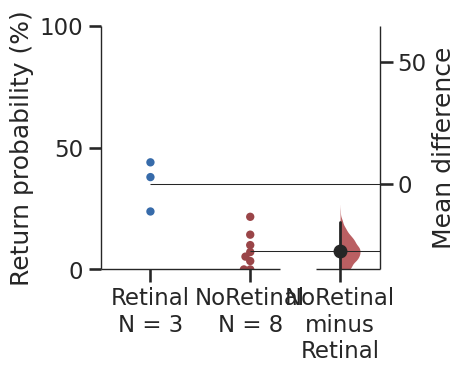

In [ ]:
sns.set_style("ticks")
sns.set_context("talk")
palette = [sns.color_palette('vlag', 1024)[0], sns.color_palette('vlag', 1024)[-1]]
my_color_palette = {"Retinal": palette[0],
                    "NoRetinal": palette[1],
                     }

dabest_event = dabest.load(event_df, idx=("Retinal", "NoRetinal"),
                             x="Category", y="return_prob")

f = dabest_event.mean_diff.plot(custom_palette=my_color_palette,
                                  swarm_label='Return probability (%)',
                                  swarm_desat=0.75,
                                  swarm_ylim = (0, 100),
                                #   contrast_ylim = (-1, 1)
                                  )

rawswarm_axes = f.axes[0]
contrast_axes = f.axes[1]

rawswarm_axes.yaxis.set_major_locator(ticker.MultipleLocator(50))
# rawswarm_axes.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
# rawswarm_axes.axhline(0, color='k', alpha=0.25, ls='--', lw=1.5)

contrast_axes.yaxis.set_major_locator(ticker.MultipleLocator(50))
# contrast_axes.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))
plt.savefig(base_dir+'/output/return_prob/' + 'Return_prob.svg', dpi=300, transparent=True, bbox_inches='tight')

plt.show()

In [ ]:
'''Instantaneous velocity components were then calculated (translation, angular
velocity, sideways velocity) and sampled using windows of a specified width (denoted here as w)
and step size (denoted here as s). The sampling procedure was as follows.'''

'''First, given frame i, the velocity components were extracted for frames i:i+w.
Angular and sideways velocity values were normalized to the first frame in the window
so that each velocity vector to originate from zero.'''

'''The resulting velocity vectors were linearized and concatenated, resulting in
a single vector of length 3w. This procedure was then repeated iteratively every
s frames for the length of the trial (t)'''

'''After each iteration the concatenated vectors were appended to a matrix with
3w rows to ultimately create t/s columns.'''

# translational velocity, angular velocity, window size, stride/step size

In [ ]:
'''Define a continuous multivariate time-series data D of dimension d with n time-steps,
D=X1,X2,…,Xn, where each Xi={x1i,…,xdi}. Let w be the window width, s the stride,
and t the start time of a sliding window in the data.'''

'''Define a new matrix Zk where each row is a vector of size w of data extracted
from the k th  dimension.'''

'''Zk(w,s,t)=⎡⎣⎢⎢⎢⎢⎢⎢xktxkt+s⋮xkt+(r−1)sxkt+1xkt+s+1⋮xkt+(r−1)s+1……⋱…xkt+w−1xkt+s+w−1⋮xkt+(r−1)s+w−1⎤⎦⎥⎥⎥⎥⎥⎥
where r is the number of desired rows, and t+(r−1)s+w−1≤n'''

'''When more than one dimension of the multivariate data is used, the data are interleaved
as depicted in (Fig. 1). As a default setting, the values of the window size (width) w
and stride (offset) s have their default values where w=60 and s=1. However, they
can be interactively changed using a slider in the system interface which gives
the user control over the parameters w and s and helps to get insight into behaviors
at different resolutions. These values are explored in the accompanying video.
The overlapping between windows is very useful for avoiding lost data and facilitating
the smooth transition between time-steps after reducing the dimensionality of the features.
Also, it helps to capture local temporal patterns in the datasets.'''

In [ ]:
# umap_df = all_df[(all_df.Fly==1) & (all_df.Category=='Retinal')].dropna()
# reducer = umap.UMAP(n_neighbors=50, min_dist=0.1)
# umap_data = umap_df[
#     [
#         "Speed",
#     ]
# ].values
# scaled_umap_data = StandardScaler().fit_transform(umap_data)
# print(scaled_umap_data)
# embedding = reducer.fit_transform(scaled_umap_data)
# print(embedding.shape)


[[ 7.93930811]
 [ 7.9726064 ]
 [ 6.5039663 ]
 ...
 [-0.42902682]
 [-0.43555151]
 [-0.45357816]]


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


KeyboardInterrupt: ignored

In [ ]:
umap_df.shape

(15900, 10)

Text(0.5, 1.0, 'UMAP projection of the Penguin dataset')

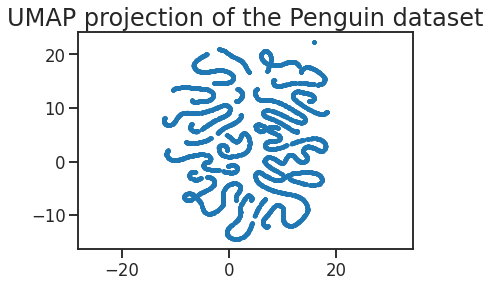

In [ ]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1], s=5)
    # c=[sns.color_palette()[x] for x in penguins.species_short.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Penguin dataset', fontsize=24)

FileNotFoundError: ignored

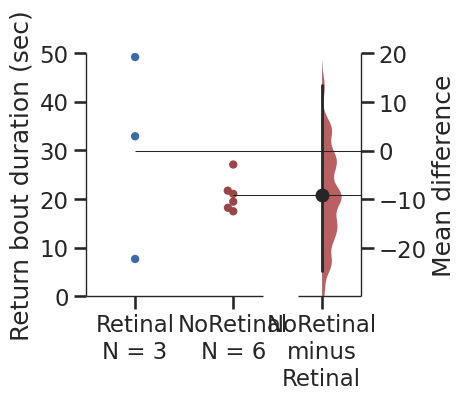

In [ ]:
sns.set_style("ticks")
sns.set_context("talk")
palette = [sns.color_palette('vlag', 1024)[0], sns.color_palette('vlag', 1024)[-1]]
my_color_palette = {"Retinal": palette[0],
                    "NoRetinal": palette[1],
                     }

dabest_zone_PI = dabest.load(maj_turn_df, idx=("Retinal", "NoRetinal"),
                             x="Category", y="T_turns")

f = dabest_zone_PI.mean_diff.plot(custom_palette=my_color_palette,
                                  swarm_label='Return bout duration (sec)',
                                  swarm_desat=0.75,
                                  swarm_ylim = (0, 50),
                                #   contrast_ylim = (-1, 1)
                                  )

rawswarm_axes = f.axes[0]
contrast_axes = f.axes[1]

rawswarm_axes.yaxis.set_major_locator(ticker.MultipleLocator(10))
# rawswarm_axes.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
# rawswarm_axes.axhline(6, color='k', alpha=0.25, ls='dotted', lw=1.5)
# rawswarm_axes.axhline(9, color='k', alpha=0.25, ls='dotted', lw=1.5)
# rawswarm_axes.axhline(41, color='k', alpha=0.25, ls='dotted', lw=1.5)
# rawswarm_axes.axhline(44, color='k', alpha=0.25, ls='dotted', lw=1.5)

# contrast_axes.yaxis.set_major_locator(ticker.MultipleLocator(10))
# contrast_axes.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))
plt.savefig(base_dir+'/output/turning_point/' + 'return_bout_duration.svg', dpi=600, transparent=True, bbox_inches='tight')

plt.show()

FileNotFoundError: ignored

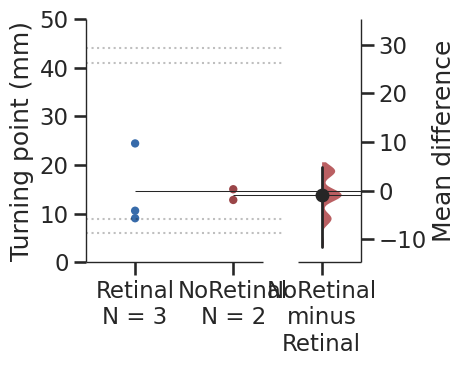

In [ ]:
sns.set_style("ticks")
sns.set_context("talk")
palette = [sns.color_palette('vlag', 1024)[0], sns.color_palette('vlag', 1024)[-1]]
my_color_palette = {"Retinal": palette[0],
                    "NoRetinal": palette[1],
                     }

dabest_zone_PI = dabest.load(maj_turn_df, idx=("Retinal", "NoRetinal"),
                             x="Category", y="Maj_turns")

f = dabest_zone_PI.mean_diff.plot(custom_palette=my_color_palette,
                                  swarm_label='Turning point (mm)',
                                  swarm_desat=0.75,
                                  swarm_ylim = (0, 50),
                                #   contrast_ylim = (-1, 1)
                                  )

rawswarm_axes = f.axes[0]
contrast_axes = f.axes[1]

# rawswarm_axes.yaxis.set_major_locator(ticker.MultipleLocator(1))
# rawswarm_axes.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
rawswarm_axes.axhline(6, color='k', alpha=0.25, ls='dotted', lw=1.5)
rawswarm_axes.axhline(9, color='k', alpha=0.25, ls='dotted', lw=1.5)
rawswarm_axes.axhline(41, color='k', alpha=0.25, ls='dotted', lw=1.5)
rawswarm_axes.axhline(44, color='k', alpha=0.25, ls='dotted', lw=1.5)

# contrast_axes.yaxis.set_major_locator(ticker.MultipleLocator(10))
# contrast_axes.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))
plt.savefig(base_dir+'/output/turning_point/' + 'turning_point.svg', dpi=600, transparent=True, bbox_inches='tight')

plt.show()

    index   Category  Fly  Maj_turns    T_turns  Bout
0       0  NoRetinal    1  20.416793  19.472977  12.0
1       1  NoRetinal    2  11.163231  21.074066   5.5
2       2  NoRetinal    3  17.370127  27.095004   9.5
3       3  NoRetinal    4  11.667392  17.492733   9.5
4       4  NoRetinal    5  14.731349  21.726031   7.0
5       5  NoRetinal    6  29.400063  18.210009   4.0
6       6    Retinal    1  12.819759  20.045638   2.0
7       7    Retinal    2  16.148453  33.954647   3.0
8       8    Retinal    3  25.243704  28.199834   1.0
9       9    Retinal    4  19.971664  23.629476   7.5
10     10    Retinal    5  22.108922  60.980648   4.5
11     11    Retinal    6  17.934109  14.073891   3.0


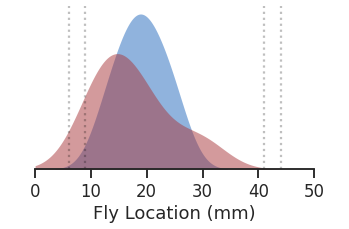

In [ ]:
import seaborn as sns
sns.set_style("ticks")
sns.set_context("talk")
# h_target = all_df[(all_df.Fly==1)].reset_index()
h_target = maj_turn_df.reset_index()
print(h_target)
# print(sns.color_palette('Spectral', 1024))
# sns.histplot(data=h_target, x="Fx",bins=25, kde=True)
palette = [sns.color_palette('vlag', 1024)[-1], sns.color_palette('vlag', 1024)[0]]
f, ax = plt.subplots(figsize=(6, 3))
sns.kdeplot(
        data=h_target, x="Maj_turns", hue="Category",
        fill=True, palette=palette, common_norm=False, clip=(0, 50),
        alpha=0.5, linewidth=0, legend=False, ax=ax)

# sns.kdeplot(
#    data=h_target, x="Fx", hue="Category",
#    fill=True, common_norm=False,
#    alpha=0.5, linewidth=0, legend=False,
# )

ax = plt.gca()

# ax.grid(False)
ax.set_xlabel('Fly Location (mm)')
ax.set_xlim([-5, 55])

ax.set_ylabel('')
ax.set_yticks([])
# ax.set_ylim([0, 0.1])
ax.axvline(6, color='k', alpha=0.25, ls=':')
ax.axvline(9, color='k', alpha=0.25, ls=':')
ax.axvline(44, color='k', alpha=0.25, ls=':')
ax.axvline(41, color='k', alpha=0.25, ls=':')
sns.despine(left=True, trim=True)
plt.savefig(base_dir+'/output/KDE/' + str(i) + '_' + str(j) + 'fly-loc_KDE.svg', dpi=300, transparent=True, bbox_inches='tight')
plt.show()
# sns.reset_orig()

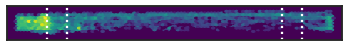

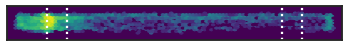

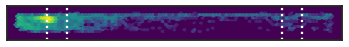

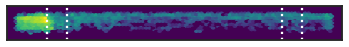

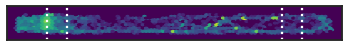

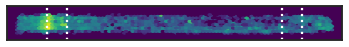

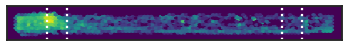

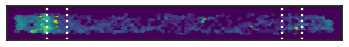

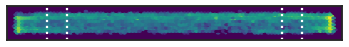

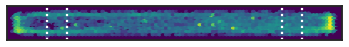

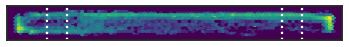

In [ ]:
# palette = [sns.color_palette('vlag', 1024)[0], sns.color_palette('vlag', 1024)[-1]]
# copy_max = max_turn_point_df.copy()
# copy_max_one = copy_max[(copy_max.Category == 'NoRetinal') & (copy_max.Fly == 7)].copy()
# cent_mass = copy_max_one.median()

sns.set_context('talk')
label = False
for i in all_df.Category.unique():
    for j in all_df[all_df.Category==i].Fly.unique():
        # h_target = all_df.reset_index()
        h_target = all_df[(all_df.Fly==j) & (all_df.Category==i)].reset_index()
        f, ax = plt.subplots()

        x = h_target.Fx.values
        y = h_target.Fy.values
        # heatmap, xedges, yedges = np.histogram2d(x, y, bins=25)

        # extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        # ax.imshow(heatmap.T, extent=[0, 50, 0, 5], origin='lower', interpolation='gaussian')
        # sns.histplot(
        #     data=h_target, x="Fx", y="Fy",
        #     bins=30, fill=True,
        #     thresh=None,
        #     ax=ax
        #     )
        ax.hexbin(x, y, gridsize=(100, 10), bins='log', cmap='viridis',
                  extent=(0, 50, 0, 5))
        # sns.kdeplot(x='Fx', y='Fy', fill=True, thresh=0,
        #             levels=100, cmap='viridis',
        #             data=h_target, ax=ax)
        # sns.despine(bottom=True, left=True)

        ax.tick_params(bottom=False, left=False)
        ax.set_xlabel('X (mm)')
        ax.set_ylabel('Y (mm)')
        ax.set_aspect('equal')
        ax.set_ylim([0, 5])
        ax.set_xlim([0, 50])
        ax.axvline(6, color='w', ls=':')
        ax.axvline(9, color='w', ls=':')
        ax.axvline(44, color='w', ls=':')
        ax.axvline(41, color='w', ls=':')
        bg = sns.color_palette('viridis', 1024)[0]
        ax.set_facecolor(bg)
        if label == False:
            ax.set_xticklabels([])
            ax.set_xlabel(None)
            ax.set_yticklabels([])
            ax.set_ylabel(None)
        plt.savefig(base_dir+'/output/heatmaps/' + str(i) + '_' + str(j) + '_heatmap.svg',dpi=300, bbox_inches='tight')
        plt.show()


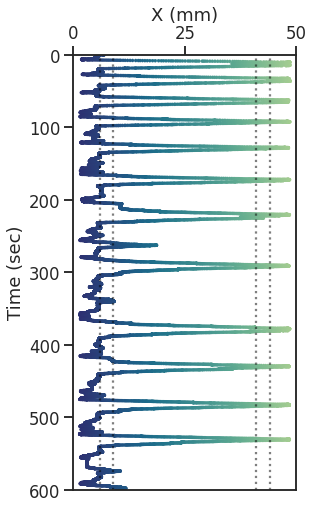

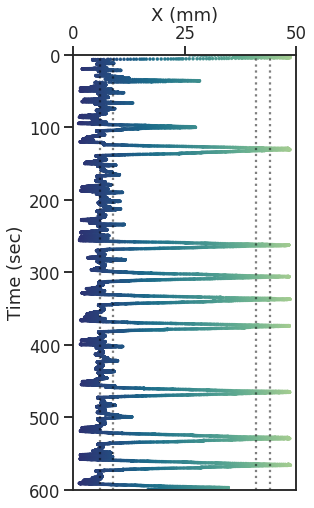

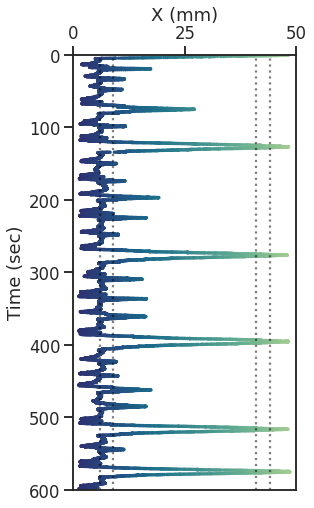

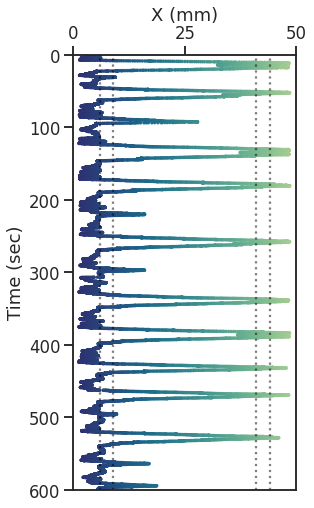

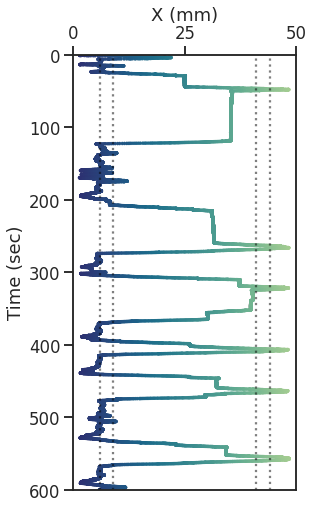

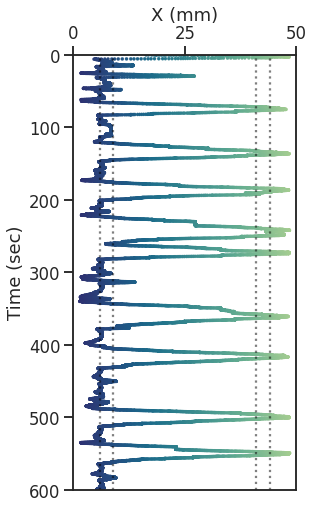

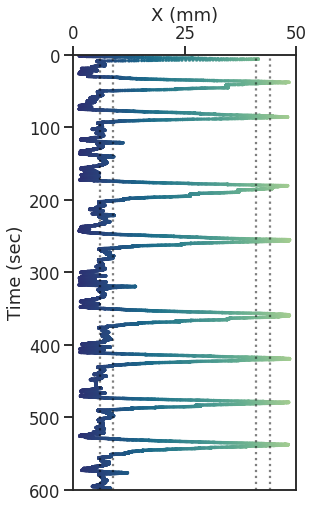

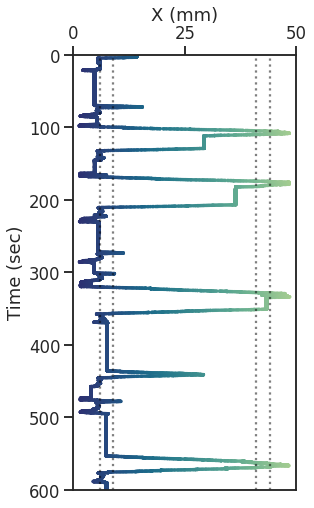

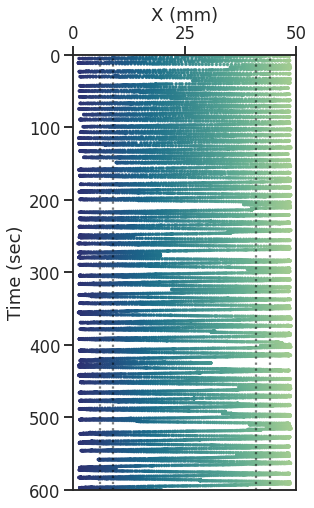

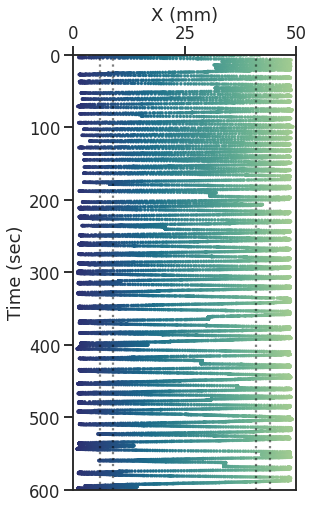

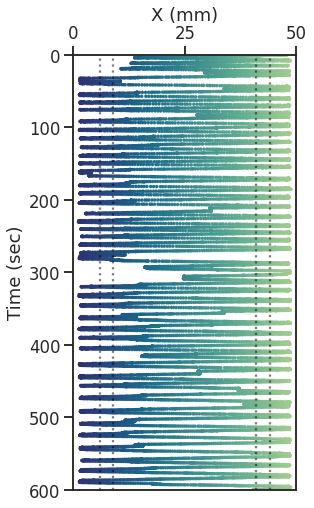

In [ ]:
label = True

sns.set_context('talk')
for i in all_df.Category.unique():
    for j in all_df[all_df.Category==i].Fly.unique():
        h_target = all_df[(all_df.Fly==j) & (all_df.Category==i)].reset_index()
        f, ax = plt.subplots(figsize=(4, 8))
        sns.scatterplot(data=h_target, x="Fx", y="Time", hue='Fx', palette='crest_r', s=10, ax=ax, legend=False, edgecolor=None)
        # ax.tick_params(bottom=False, left=False)
        ax.set_xlabel('X (mm)')
        ax.set_ylabel('Time (sec)')
        ax.set_ylim([0, 600])
        ax.set_xlim([0, 50])
        # ax.set_yticks([0, 300, 600])
        ax.set_xticks([0, 25, 50])
        ax.xaxis.set_label_position('top')
        ax.xaxis.tick_top()
        ax.invert_yaxis()
        ax.axvline(6, color='k', ls=':', alpha=0.5)
        ax.axvline(9, color='k', ls=':', alpha=0.5)
        ax.axvline(44, color='k', ls=':', alpha=0.5)
        ax.axvline(41, color='k', ls=':', alpha=0.5)
        if label == False:
            ax.set_xticklabels([])
            ax.set_xlabel(None)
            ax.set_yticklabels([])
            ax.set_ylabel(None)
        plt.savefig(base_dir+'/output/X_loc/' + str(i) + '_' + str(j) + '_X_loc.svg', dpi=300, transparent=True, bbox_inches='tight')
        plt.show()

In [ ]:
all_chunks =[]
for k in all_df.Category.unique():
    for j in all_df[all_df.Category==k].Fly.unique():
        chunks = []
        ext_df = all_df[(all_df.Fly == j) & (all_df.Category == k)][['Time', 'LED', 'Speed']]
        idx = ext_df[ext_df.LED == True].index.values
        for i, id in enumerate(idx):
            t0 = ext_df.loc[id].Time
            t_t0 = ext_df.Time - t0
            if t_t0[0] > -1:
                pass
            else:
                idx_a = t_t0[(t_t0 >= -1) & (t_t0 <= 4)].index.values
                chunk = ext_df.loc[idx_a]
                chunk['Time'] = chunk['Time'] - t0

                last = chunk['Time'].values[-1]
                sample_rate = 0.05
                rng = np.arange(-1, last+sample_rate, sample_rate)
                ds = chunk.groupby(pd.cut(chunk['Time'], rng)).median()

                ds.interpolate(method='linear', limit_direction='both', axis=0, inplace=True)
                ds.reset_index(drop=True, inplace=True)
                ds['Activation'] = i
                ds['Time'] = sample_rate * ds.index -1
                chunks.append(ds)
                # ds['Fly'] = i+1
                # ds.drop(['Latency'], axis=1, inplace=True)
                # ds['RoiActivity'] = ds['Fx']>=540
                # ds['RoiActivity']=ds['RoiActivity'].astype(int)
                # ds.plot(x='Time', y='Speed')
        # print(i, j, k)
        chunks_df = pd.concat(chunks)
        chunks_df = chunks_df.groupby('Time').mean()
        chunks_df['Fly'] = j
        chunks_df['Category'] = k
        chunks_df.drop(['Activation', 'LED'], axis=1, inplace=True)
        all_chunks.append(chunks_df)
all_chunks = pd.concat(all_chunks)
all_chunks

,Speed,Fly,Category
Time,,,
-1.00,7.148861,1,Retinal
-0.95,5.980365,1,Retinal
-0.90,6.406802,1,Retinal
-0.85,7.164159,1,Retinal
-0.80,8.052239,1,Retinal
...,...,...,...
3.75,-4.248883,12,NoRetinal
3.80,-3.365814,12,NoRetinal
3.85,-3.829902,12,NoRetinal


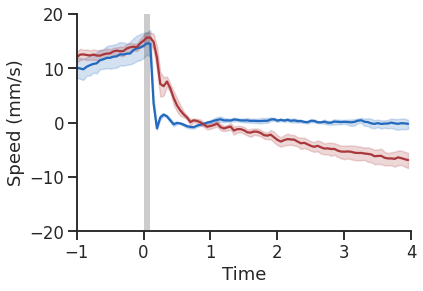

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(x="Time", y="Speed",
             hue="Category", palette=my_color_palette, legend=False,
             data=all_chunks.reset_index(),
             ax= ax)

ax.axvspan(0, 0.1, color='k', alpha=0.2, lw=0)
ax.set_xlim([-1, 4])
ax.set_ylim([-20,20])
ax.set_ylabel('Speed (mm/s)')
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
sns.despine(trim=True)
plt.savefig(base_dir+'/output/speed/' + str(i) + '_' + str(j) + '_X_loc.svg', dpi=600, transparent=True, bbox_inches='tight')
plt.show()

In [ ]:
# extract = node_df[(node_df['from']==1.0)].reset_index()
# max_turn_point_list = []
# for j in all_df.Category.unique():
#     for i in all_df[all_df.Category==j].Fly.unique():
#         fly_num = i
#         ext = extract[(extract.Fly ==fly_num) & (extract.Category ==j)].copy()
#         # print(ext)
#         idx = ext[(ext['to']==2.0)&(ext['to'].diff()==0)].index
#         ext.drop(idx, inplace=True)
#         # print(ext)
#         slcs = []
#         for k in ext.index.values[:-1]:
#             if ext.loc[k]['to'] == 2.0:
#                 pass
#             else:
#                 dura = (ext.loc[k+1]['Time'] - ext.loc[k]['Time'])
#                 # print(dura)
#                 slcs.append(slice(ext.loc[k]['index'], ext.loc[k+1]['index']))

#         for slc in slcs:
#             slc_df = all_df[(all_df.Fly==fly_num)][slc]
#             max_turn_point = slc_df[slc_df.Fx == slc_df.Fx.max()][['Fx', 'Fy']]
#             mxX = max_turn_point.values[0][0]
#             mxY = max_turn_point.values[0][1]
#             max_turn_point_list.append([mxX, mxY, j, i])
#             # print(max_turn_point.values[0])

#         # node_list.append(b[['Time', 'Fly', 'Category', 'from', 'to']])

# max_turn_point_df = pd.DataFrame(max_turn_point_list, columns=['mxX', 'mxY', 'Category', 'Fly'])
# max_turn_point_df

In [ ]:

# for j in all_df.Category.unique():
#     for i in all_df[all_df.Category==j].Fly.unique():
#         extract = node_df[(node_df['from']==1.0) & ((node_df['to']==1.0) | (node_df['to']==2.0))].reset_index()
#         extract[((extract['from'].diff()==0) & (extract['to'].diff()==0)) | ((extract['from'].diff()==0) & (extract['to'].diff()==-1))]
#         slc = extract[((extract['from'].diff()==0) & (extract['to'].diff()==0) & (extract['to']==1.0))| ((extract['from'].diff()==0) & (extract['to'].diff()==-1))]
#         all_df[(all_df.Fly==i) & (all_df.Category==j)]
# cond_1 = (node_df['from']==1.0) & ((node_df['to']==1.0) | (node_df['to']==2.0))
# cond_2 = ((extract['from'].diff()==0) & (extract['to'].diff()==0) & (extract['to']==1.0)) | ((extract['from'].diff()==0) & (extract['to'].diff()==-1))
# # extract = node_df[cond_1 & cond_2].reset_index()
fly_num = 7
extract = node_df[(node_df['from']==1.0)].reset_index()
# extract[(extract.Fly ==1) & (extract.Category =='Retinal')].drop((extract['to']==2.0)&(extract['to'].diff()==0))
# extract = extract[(extract.Fly ==fly_num) & (extract.Category =='Retinal')]
extract = extract[(extract.Fly ==fly_num) & (extract.Category =='NoRetinal')]
print(extract)
idx = extract[(extract['to']==2.0)&(extract['to'].diff()==0)].index
extract.drop(idx, inplace=True)
print(extract)
slcs = []
for i in extract.index.values[:-1]:
    if extract.loc[i]['to'] == 2.0:
        pass
    else:
        print(extract.loc[i+1]['Time'] - extract.loc[i]['Time'])
        slcs.append(slice(extract.loc[i]['index'], extract.loc[i+1]['index']))
    # ex
# print(extract[(extract.Fly ==1) & (extract.Category =='Retinal')])
slcs
for slc in slcs:
    slc_df = all_df[(all_df.Fly==fly_num)][slc]
    print(slc_df[slc_df.Fx == slc_df.Fx.max()][['Fx', 'Fy']])
    # print(slc_df)
# extract[((extract['from'].diff()==0) & (extract['to'].diff()==0)) | ((extract['from'].diff()==0) & (extract['to'].diff()==-1))]
# slc = extract[((extract['from'].diff()==0) & (extract['to'].diff()==0) & (extract['to']==1.0)) | ((extract['from'].diff()==0) & (extract['to'].diff()==-1))]
# slc
# slc[(slc.Fly ==1)]
# slice(8811, 9891)
# all_df[(all_df.Fly==1)][slice(8811, 9891)].Fx.max()

     index        Time  Fly   Category  from   to
329   1373   45.767356    7  NoRetinal   1.0  2.0
330   2089   69.635291    7  NoRetinal   1.0  2.0
331   2461   82.035562    7  NoRetinal   1.0  1.0
332   2752   91.735671    7  NoRetinal   1.0  2.0
333   3244  108.136650    7  NoRetinal   1.0  2.0
334   3844  128.136785    7  NoRetinal   1.0  2.0
335   4831  161.037096    7  NoRetinal   1.0  2.0
336   6002  200.072266    7  NoRetinal   1.0  2.0
337   6432  214.405442    7  NoRetinal   1.0  2.0
338   7005  233.506403    7  NoRetinal   1.0  2.0
339   7646  254.873917    7  NoRetinal   1.0  2.0
340   8234  274.475417    7  NoRetinal   1.0  2.0
341   8670  289.008724    7  NoRetinal   1.0  2.0
342   9616  320.542483    7  NoRetinal   1.0  2.0
343  10178  339.276359    7  NoRetinal   1.0  2.0
344  10842  361.410201    7  NoRetinal   1.0  2.0
345  11366  378.876718    7  NoRetinal   1.0  2.0
346  11971  399.044145    7  NoRetinal   1.0  2.0
347  12693  423.112170    7  NoRetinal   1.0  2.0


In [ ]:
node_df

,Time,Fly,Category,from,to
37,1.234011,1,Retinal,2.0,1.0
141,4.701449,1,Retinal,1.0,2.0
382,12.734789,1,Retinal,2.0,1.0
502,16.733925,1,Retinal,1.0,1.0
874,29.134779,1,Retinal,1.0,2.0
...,...,...,...,...,...
16607,553.583754,8,NoRetinal,1.0,2.0
16983,566.116375,8,NoRetinal,2.0,1.0
17252,575.083838,8,NoRetinal,1.0,2.0
17456,581.884355,8,NoRetinal,2.0,1.0


In [ ]:
# # four axes this time
# axis_z1 = Axis(axis_id="Z1", start=0, end=600, angle=70, long_name="Z1")
# axis_z1_repeat = Axis(axis_id="Z1_repeat", start=0, end=600, angle=110, long_name="Z1")

# axis_z2 = Axis(axis_id="Z2", start=0, end=600, angle=190, long_name="Z2")
# axis_z2_repeat = Axis(axis_id="Z2_repeat", start=0, end=600, angle=230, long_name="Z2")

# axes = [axis_z1, axis_z1_repeat, axis_z2, axis_z2_repeat]

# hp = HivePlot()
# hp.add_nodes(nodes)
# hp.add_axes(axes)

# # place the *same* nodes on repeat axes (not specifying vmin and vmax here)
# hp.place_nodes_on_axis(axis_id="l",
#                        unique_ids=np.arange(num_nodes)[:num_nodes//3],
#                        sorting_feature_to_use="low")
# hp.place_nodes_on_axis(axis_id="l_repeat",
#                        unique_ids=np.arange(num_nodes)[:num_nodes//3],
#                        sorting_feature_to_use="low")

# hp.place_nodes_on_axis(axis_id="m",
#                        unique_ids=np.arange(num_nodes)[num_nodes//3: 2*num_nodes//3],
#                        sorting_feature_to_use="med")
# hp.place_nodes_on_axis(axis_id="m_repeat",
#                        unique_ids=np.arange(num_nodes)[num_nodes//3: 2*num_nodes//3],
#                        sorting_feature_to_use="med")

# hp.place_nodes_on_axis(axis_id="h",
#                        unique_ids=np.arange(num_nodes)[2*num_nodes//3:],
#                        sorting_feature_to_use="high")
# hp.place_nodes_on_axis(axis_id="h_repeat",
#                        unique_ids=np.arange(num_nodes)[2*num_nodes//3:],
#                        sorting_feature_to_use="high")

# # same edges as before, but we need to be careful to not overlap other axes
# hp.connect_axes(edges=edges, axis_id_1="l_repeat", axis_id_2="m", c="C1")

# # both directions, different style
# hp.connect_axes(edges=edges, axis_id_1="l", axis_id_2="h_repeat", c="C2", ls="dotted")

# # different styles in each direction
# hp.connect_axes(edges=edges, axis_id_1="h", axis_id_2="m_repeat", a2_to_a1=False, c="C0")
# hp.connect_axes(edges=edges, axis_id_1="h", axis_id_2="m_repeat", a1_to_a2=False, c="C0", ls="--")

# # plus the repeat edges (no need to do bidirectional here, just leads to the edges but flipped)
# hp.connect_axes(edges=edges, axis_id_1="l", axis_id_2="l_repeat", a2_to_a1=False, c="C4")
# hp.connect_axes(edges=edges, axis_id_1="m", axis_id_2="m_repeat", a2_to_a1=False, c="C5")
# hp.connect_axes(edges=edges, axis_id_1="h", axis_id_2="h_repeat", a2_to_a1=False, c="C6")

NameError: ignored

In [ ]:
control = zone_df[zone_df.Category == 'NoRetinal'].Zone_PI.reset_index(drop=True)
test = zone_df[zone_df.Category == 'Retinal'].Zone_PI.reset_index(drop=True)
dabest_df = pd.concat([control, test], axis=1)
dabest_df.columns = ['-Retinal', '+Retinal']
two_groups_unpaired = dabest.load(dabest_df, idx=('-Retinal', '+Retinal'), resamples=5000)
two_groups_unpaired.mean_diff.results

# pd.DataFrame([control, test], columns=['Control', 'Test'])

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,bca_interval_idx,pct_low,pct_high,pct_interval_idx,bootstraps,resamples,random_seed,pvalue_permutation,permutation_count,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,-Retinal,+Retinal,8,12,mean difference,False,0.53018,95,0.273349,0.74354,"(91, 4835)",0.288497,0.757028,"(125, 4875)","[0.06446468578894687, 0.09255338342640669, 0.1...",5000,12345,0.0018,5000,0.000395,-4.339667,0.000868,-3.985416,0.001524,9.0


In [ ]:
# zone_target_list = []
# for i in all_df.Fly.unique():
#     a = all_df[(all_df.Fly==i)].dropna()
#     b = a[a.Zone.shift() != a.Zone]
#     b = b.drop(b[b.Zone==3].index)
#     b['from'] = b.Zone
#     b['to'] = b.Zone.shift(-1)
#     b.dropna(inplace=True)
#     total_events = len(b.index.values)
#     z1toz2 = ((b['from']==1) & (b['to']==2)).sum()/total_events
#     z2toz1 = ((b['from']==2) & (b['to']==1)).sum()/total_events
#     z1toz1 = ((b['from']==1) & (b['to']==1)).sum()/total_events
#     z2toz2 = ((b['from']==2) & (b['to']==2)).sum()/total_events
#     zone_target_list.append([z1toz2, z2toz1, z1toz1, z2toz2])
# event_df = pd.DataFrame(zone_target_list, columns=['z1toz2', 'z2toz1', 'z1toz1', 'z2toz2'])
# event_df

,z1toz2,z2toz1,z1toz1,z2toz2
0,0.413043,0.402174,0.141304,0.043478
1,0.364865,0.351351,0.283784,0.000000
2,0.409639,0.397590,0.024096,0.168675
3,0.432099,0.432099,0.061728,0.074074
4,0.460317,0.444444,0.079365,0.015873
5,0.443038,0.430380,0.126582,0.000000
6,0.478261,0.463768,0.043478,0.014493
7,0.372549,0.352941,0.274510,0.000000


In [ ]:
test = b.groupby(['from', 'to']).count().reset_index()[['from', 'to', 'Zone']]
test['Zone'] = test['Zone']/test.Zone.sum()
test

,from,to,Zone
0,1.0,1.0,0.274510
1,1.0,2.0,0.372549
2,2.0,1.0,0.352941


          0         1
0  0.036853  0.484408
1  0.477235  0.001504


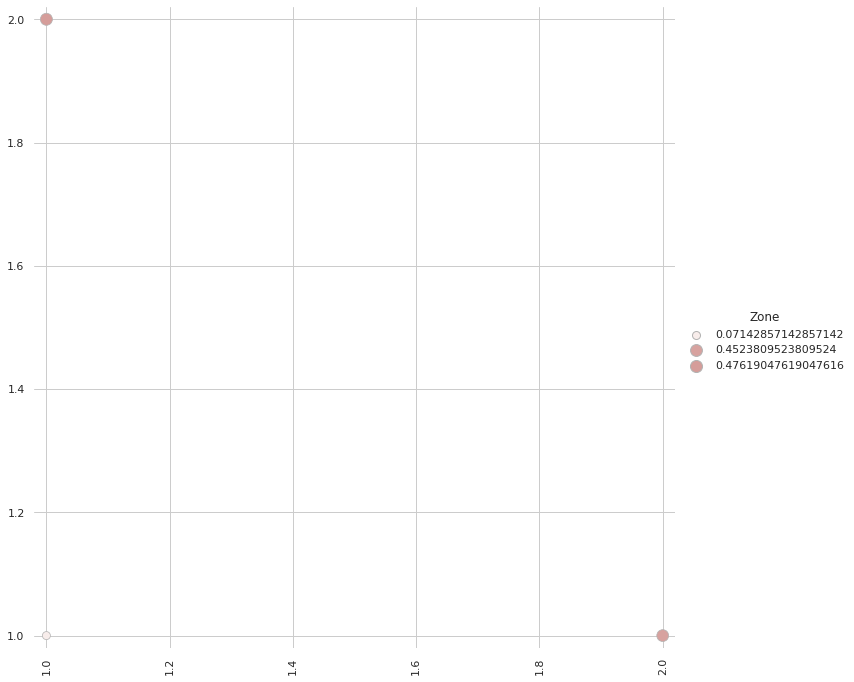

In [ ]:
corr_list = [[event_df.z1toz1.mean(), event_df.z1toz2.mean()],
             [event_df.z2toz1.mean(), event_df.z2toz2.mean()]]
corr_mat = pd.DataFrame(corr_list)
print(corr_mat)
g = sns.relplot(
    data=test,
    x="from", y="to", hue="Zone", size="Zone",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(0, 1),
)

# Tweak the figure to finalize
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)
for artist in g.legend.legendHandles:
    artist.set_edgecolor(".7")

        index        Time   Latency  ...      Speed  TurningSpeed  Zone
0           0    0.000000  0.000000  ...        NaN           NaN   3.0
1           1    0.033131  0.033131  ...  26.296206     16.850669   NaN
2           2    0.066723  0.033593  ...  20.766726     59.129566   NaN
3           3    0.100072  0.033348  ...  26.468236     56.656832   NaN
4           4    0.133432  0.033361  ...  28.330843     75.356424   1.0
...       ...         ...       ...  ...        ...           ...   ...
143971  17992  599.751643  0.034007  ...   0.068392      0.156494   3.0
143972  17993  599.784753  0.033110  ...   0.277206      0.394810   3.0
143973  17994  599.818195  0.033442  ...   0.385237      0.178564   3.0
143974  17995  599.852477  0.034281  ...   0.237432      0.116597   3.0
143975  17996  599.884185  0.031709  ...   0.131001      0.035309   3.0

[143976 rows x 10 columns]


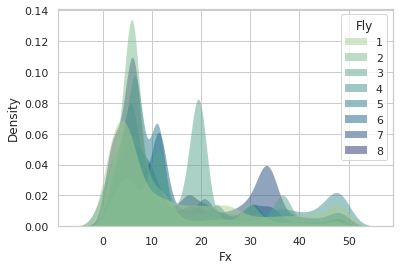

In [ ]:
import seaborn as sns
h_target = all_df[(all_df.Fly==1)].reset_index()
h_target = all_df.reset_index()
print(h_target)
# sns.histplot(data=h_target, x="Fx",bins=25, kde=True)

sns.kdeplot(
   data=h_target, x="Fx", hue="Fly",
   fill=True, common_norm=False, palette="crest",
   alpha=0.5, linewidth=0,
)

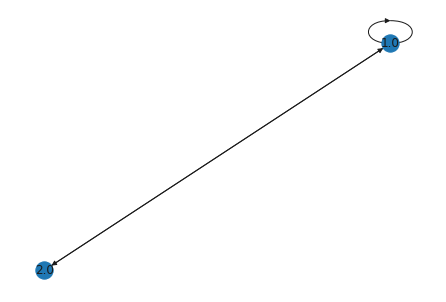

In [ ]:
# libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


# Build your graph
G=nx.from_pandas_edgelist(b, 'from', 'to', create_using=nx.DiGraph())
# G=nx.from_pandas_edgelist(b, 'from', 'to')
# Plot it
nx.draw(G, with_labels=True)
plt.show()

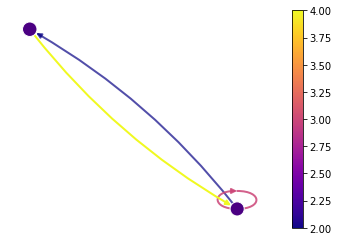

In [ ]:
import matplotlib as mpl
seed = 1111
pos = nx.spring_layout(G, k=0.01, seed=seed)

node_sizes = [200 + 10 * i for i in range(len(G))]
M = G.number_of_edges()
edge_colors = range(2, M + 2)
edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
cmap = plt.cm.plasma

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="indigo", edgecolors='w')
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    arrowstyle="-|>",
    arrowsize=10,
    connectionstyle='arc3,rad=0.1',
    edge_color=edge_colors,
    edge_cmap=cmap,
    width=2,
)
# set alpha value for each edge
for i in range(M):
    edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=cmap)
pc.set_array(edge_colors)
plt.colorbar(pc)

ax = plt.gca()
ax.set_axis_off()
plt.show()

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# Load the brain networks dataset, select subset, and collapse the multi-index
df = sns.load_dataset("brain_networks", header=[0, 1, 2], index_col=0)
used_networks = [1, 5, 6, 7, 8, 12, 13, 17]
used_columns = (df.columns
                  .get_level_values("network")
                  .astype(int)
                  .isin(used_networks))
df = df.loc[:, used_columns]

df.columns = df.columns.map("-".join)

# Compute a correlation matrix and convert to long-form
corr_mat = df.corr().stack().reset_index(name="correlation")

In [ ]:
corr_mat


,level_0,level_1,correlation
0,1-1-lh,1-1-lh,1.000000
1,1-1-lh,1-1-rh,0.881516
2,1-1-lh,5-1-lh,0.431619
3,1-1-lh,5-1-rh,0.418708
4,1-1-lh,6-1-lh,-0.084634
...,...,...,...
1439,17-4-lh,17-2-lh,0.517481
1440,17-4-lh,17-2-rh,0.256544
1441,17-4-lh,17-3-lh,0.264381
1442,17-4-lh,17-3-rh,0.090302


In [ ]:
rcm = list(nx.utils.reverse_cuthill_mckee_ordering(G))
print("ordering", rcm)
A = nx.laplacian_matrix(G)
x, y = np.nonzero(A)
# print(f"lower bandwidth: {(y - x).max()}")
# print(f"upper bandwidth: {(x - y).max()}")
print(f"bandwidth: {(y - x).max() + (x - y).max() + 1}")
print(A)

B = nx.laplacian_matrix(G, nodelist=rcm)
print("low-bandwidth Laplacian matrix")
x, y = np.nonzero(B)
# print(f"lower bandwidth: {(y - x).max()}")
# print(f"upper bandwidth: {(x - y).max()}")
print(f"bandwidth: {(y - x).max() + (x - y).max() + 1}")
print(B)

sns.heatmap(B.todense(), cbar=False, square=True, linewidths=0.5, annot=True)
plt.show()

NetworkXNotImplemented: ignored

In [ ]:
# d = all_df[all_df.Time <= 90]
d = all_df
x = d.Fx
y = d.Fy
center_x = 13
center_y = 13
radius = 13
fig, ax = plt.subplots()

circ = patches.Circle((center_x, center_y), radius, lw=3, edgecolor='k',facecolor='none')
ax.add_patch(circ) # Plot the outline

heatmap, xedges, yedges = np.histogram2d(x, y, bins=25)

heatmap = np.pad(heatmap, pad_width=1)

ax.imshow(heatmap.T,
          clip_path=circ,
          clip_on=True,
          origin='lower',
          interpolation='gaussian')

ax.axvline(x=13, ymin=0.02, ymax=0.98, color='w', ls='--', lw=1)
ax.set_axis_off()
ax.set_aspect('equal')

# if save_fig_path:
plt.savefig(base_dir+'/output/heatmap.png', transparent=True, dpi=600, bbox_inches='tight')

plt.show()
print(((d.RoiActivity.sum() / len(d.RoiActivity))*2)-1)

AttributeError: ignored

In [ ]:
import numpy.ma as ma
import itertools

# revisit count
revisited = []
interval = []
num_fly = len(all_df.Fly.unique())
pix_mid = 540
radius = 20
# print(num_fly)

def split(arr, cond):
  return [arr[cond], arr[~cond]]

visits = []
intervals = []
speeds = []
dist_borders = []
pis = []

for j in range(num_fly):
    dat = all_df[(all_df.Fly == j+1)]
    arr = dat['RoiActivity']
    arr = np.array([ sum( 1 for _ in group ) for key, group in itertools.groupby( arr ) if key ])
    visit = len(arr)
    interval = arr.mean() / 20
    speed = dat[dat.RoiActivity == 1].Speed.mean()
    dist_border = ((abs(dat.Fx - pix_mid) / pix_mid) * radius).mean()
    pi = (dat.RoiActivity.sum() / len(dat.RoiActivity)) *2 -1

    visits.append(visit)
    intervals.append(interval)
    speeds.append(speed)
    dist_borders.append(dist_border)
    pis.append(pi)

visits = pd.Series(visits)
intervals = pd.Series(intervals)
speeds = pd.Series(speeds)
dist_borders = pd.Series(dist_borders)
pis = pd.Series(pis)

whole_list = [visits, intervals, speeds, dist_borders, pis]

for i in range(5):
    cat = ['visit', 'interval', 'speed', 'dist_border', 'pi']
    save_csv_path = base_dir + 'output/' + cat[i] + '.csv'
    final = whole_list[i]
    final.to_csv(save_csv_path, header=False, index=False)
    print('File saved:' + save_csv_path)

File saved:/content/drive/My Drive/00_project/05_fly-arena/4_BinaryChoice-Food/Nutrition-starved/Sexually-sated/WaterVS100mMSUC/Batch1/{+}{+};{+}{TNTe}/output/visit.csv
File saved:/content/drive/My Drive/00_project/05_fly-arena/4_BinaryChoice-Food/Nutrition-starved/Sexually-sated/WaterVS100mMSUC/Batch1/{+}{+};{+}{TNTe}/output/interval.csv
File saved:/content/drive/My Drive/00_project/05_fly-arena/4_BinaryChoice-Food/Nutrition-starved/Sexually-sated/WaterVS100mMSUC/Batch1/{+}{+};{+}{TNTe}/output/speed.csv
File saved:/content/drive/My Drive/00_project/05_fly-arena/4_BinaryChoice-Food/Nutrition-starved/Sexually-sated/WaterVS100mMSUC/Batch1/{+}{+};{+}{TNTe}/output/dist_border.csv
File saved:/content/drive/My Drive/00_project/05_fly-arena/4_BinaryChoice-Food/Nutrition-starved/Sexually-sated/WaterVS100mMSUC/Batch1/{+}{+};{+}{TNTe}/output/pi.csv


       index    Time         Fx          Fy  Fly  RoiActivity      Speed
0          0    0.00  665.50400  826.184300    1            1        NaN
1          1    0.05  666.19205  827.309400    1            1   0.976897
2          2    0.10  666.70570  828.577100    1            1   1.013191
3          3    0.15  665.78915  828.164750    1            1   0.744471
4          4    0.20  664.92830  828.353500    1            1   0.652815
...      ...     ...        ...         ...  ...          ...        ...
51534   5936  296.80  589.16575   42.794135   12            1  10.084972
51535   5937  296.85  578.57460   43.714310   12            1   7.874850
51536   5938  296.90  571.22780   42.038640   12            1   5.581831
51537   5939  296.95  557.52195   39.585030   12            1  10.313881
51538   5940  297.00  540.18880   38.618495   12            1  12.859316

[51539 rows x 7 columns]


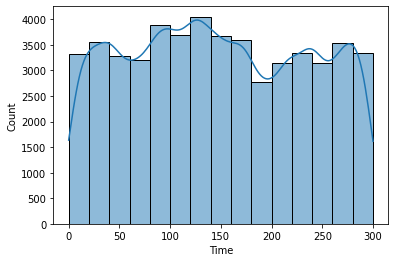

In [ ]:
import seaborn as sns
h_target = all_df[(all_df.RoiActivity==1)].reset_index()
print(h_target)
sns.histplot(data=h_target, x="Time",bins=15, kde=True)